In [18]:
!pip install numpy pandas scikit-learn matplotlib seaborn umap-learn
import pandas as pd
data = pd.read_csv("data.csv")

## Data Preprocessing Pipeline: Dropping Identifier Columns, Removing Highly Correlated Features, Ordinal Encoding Categorical Variables, Dropping Text Target Column, Converting Boolean-Like Columns, Scaling Numeric Features, Creating Baseline Dataset, Train–Test Split, Preparing Data for Random Forest

In [ ]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

identifier_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("Identifier columns:", identifier_cols)
data = data.drop(columns=identifier_cols)

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
corr_matrix = data[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]
data = data.drop(columns=to_drop_corr)

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if "loan_status" in categorical_cols:
    categorical_cols.remove("loan_status")

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data[categorical_cols] = enc.fit_transform(data[categorical_cols])

if "loan_status" in data.columns:
    data = data.drop(columns=["loan_status"])

bool_like_cols = []
for col in data.columns:
    unique_vals = set(str(v).lower() for v in data[col].dropna().unique())
    if unique_vals.issubset({"true","false","t","f","yes","no","y","n"}):
        bool_like_cols.append(col)

for col in bool_like_cols:
    data[col] = data[col].astype(str).str.lower().map({
        "true":1,"t":1,"yes":1,"y":1,
        "false":0,"f":0,"no":0,"n":0
    }).astype(int)

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
if "default_binary" in numeric_cols:
    numeric_cols.remove("default_binary")

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
print("Scaling complete. Shape:", data.shape)

noerror_data = data.copy()
print("Baseline dataset created.")
print(noerror_data.shape)

X = noerror_data.drop(columns=["default_binary"])
y = noerror_data["default_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Random Forest preprocessing complete. Ready for model training.")

Identifier columns: []
Scaling complete. Shape: (10000, 76)
Baseline dataset created.
(10000, 76)
Train: (7500, 75) Test: (2500, 75)
Random Forest preprocessing complete. Ready for model training.


## Baseline Random Forest: Initial Hyperparameters, 100 Trees Setup, Reproducibility via Random State, Default Parameters Retained, Model Trained on Preprocessed Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

results = {
    "baseline_rf": {}
}

print("Baseline Random Forest trained with 100 trees.")

Baseline Random Forest trained with 100 trees.


## Random Forest Hyperparameter Tuning: Searching Optimal n_estimators, Testing 10–200 Trees, Training Models Per Setting, Recording Train/Test Accuracies, Plotting Accuracy Trends, Identifying Stabilization Point

n_estimators=10: Train=0.9980, Test=0.9540
n_estimators=25: Train=0.9999, Test=0.9616
n_estimators=50: Train=1.0000, Test=0.9656
n_estimators=75: Train=1.0000, Test=0.9636
n_estimators=100: Train=1.0000, Test=0.9664
n_estimators=125: Train=1.0000, Test=0.9668
n_estimators=150: Train=1.0000, Test=0.9672
n_estimators=175: Train=1.0000, Test=0.9684
n_estimators=200: Train=1.0000, Test=0.9692


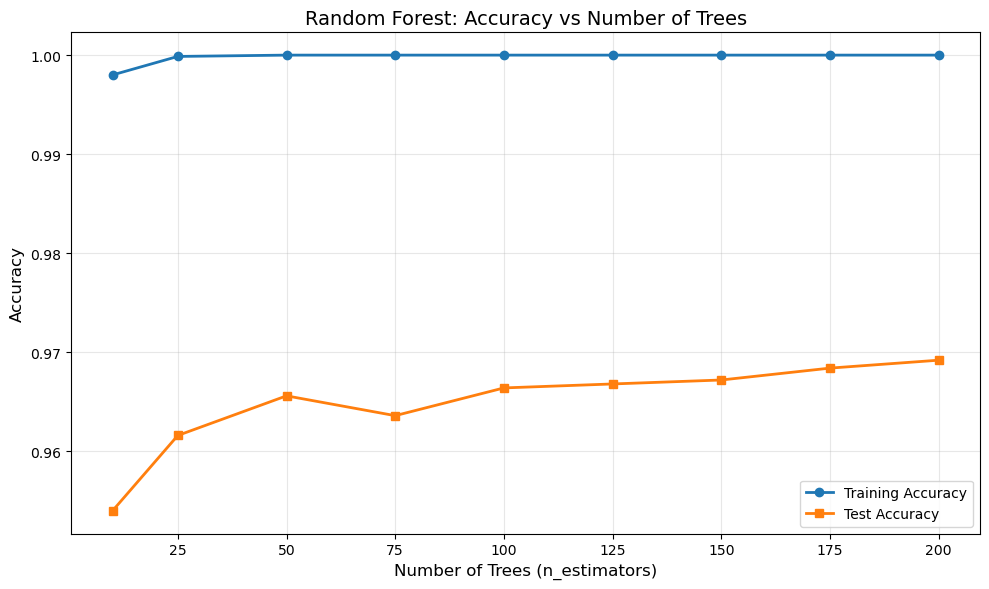


Best n_estimators: 200 with Test Accuracy: 0.9692


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

n_estimators_range = [10, 25, 50, 75, 100, 125, 150, 175, 200]

train_accuracies = []
test_accuracies = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    
    train_acc = rf_temp.score(X_train, y_train)
    test_acc = rf_temp.score(X_test, y_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"n_estimators={n_est}: Train={train_acc:.4f}, Test={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, marker='o', label='Training Accuracy', linewidth=2)
plt.plot(n_estimators_range, test_accuracies, marker='s', label='Test Accuracy', linewidth=2)
plt.xlabel('Number of Trees (n_estimators)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Random Forest: Accuracy vs Number of Trees', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_idx = test_accuracies.index(max(test_accuracies))
best_n_estimators = n_estimators_range[best_idx]
print(f"\nBest n_estimators: {best_n_estimators} with Test Accuracy: {test_accuracies[best_idx]:.4f}")

## Measuring Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

results["baseline_rf"]["train_accuracy"] = train_acc
results["baseline_rf"]["test_accuracy"] = test_acc
results["baseline_rf"]["train_predictions"] = y_train_pred
results["baseline_rf"]["test_predictions"] = y_test_pred

print("=" * 50)
print("RANDOM FOREST MODEL ACCURACY")
print("=" * 50)
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Difference:        {(train_acc - test_acc):.4f}")
print("=" * 50)

RANDOM FOREST MODEL ACCURACY
Training Accuracy: 1.0000 (100.00%)
Test Accuracy:     0.9692 (96.92%)
Difference:        0.0308


## Confusion Matrix

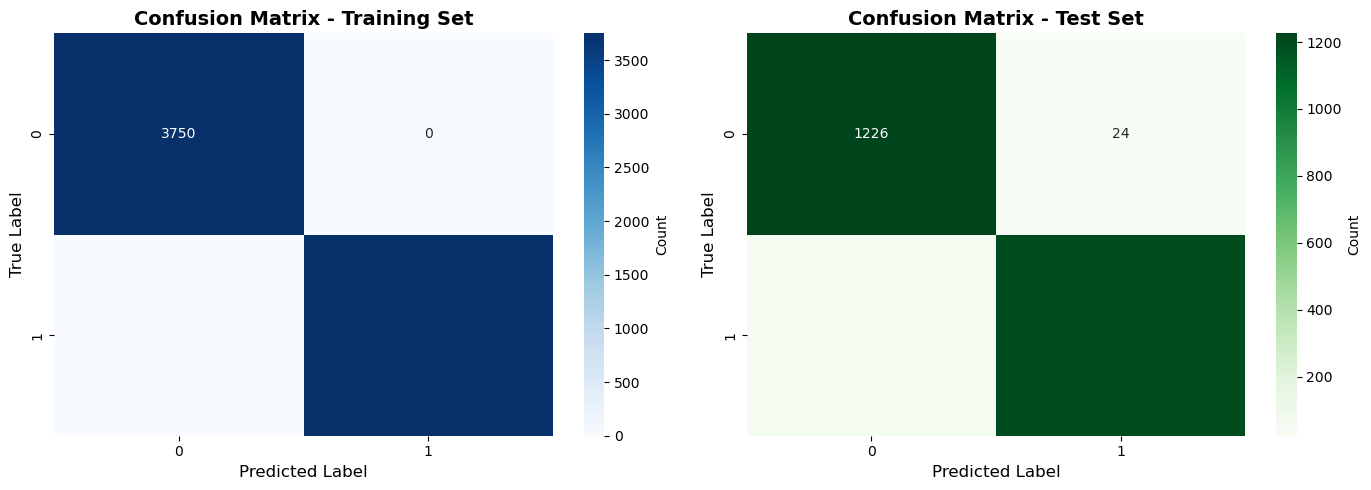

Confusion Matrix - Training Set:
[[3750    0]
 [   0 3750]]

Confusion Matrix - Test Set:
[[1226   24]
 [  53 1197]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

print("Confusion Matrix - Training Set:")
print(cm_train)
print("\nConfusion Matrix - Test Set:")
print(cm_test)

## Precision, Recall F1 Score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

results["baseline_rf"]["train_precision"] = train_precision
results["baseline_rf"]["train_recall"] = train_recall
results["baseline_rf"]["train_f1"] = train_f1
results["baseline_rf"]["test_precision"] = test_precision
results["baseline_rf"]["test_recall"] = test_recall
results["baseline_rf"]["test_f1"] = test_f1

print("=" * 60)
print("PRECISION / RECALL / F1-SCORE")
print("=" * 60)
print("\nTRAINING SET:")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")

print("\nTEST SET:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print("=" * 60)

print("\n\nDETAILED CLASSIFICATION REPORT - TEST SET:")
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))

PRECISION / RECALL / F1-SCORE

TRAINING SET:
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

TEST SET:
  Precision: 0.9803
  Recall:    0.9576
  F1-Score:  0.9688


DETAILED CLASSIFICATION REPORT - TEST SET:
              precision    recall  f1-score   support

  No Default       0.96      0.98      0.97      1250
     Default       0.98      0.96      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



## ROC AUC Score

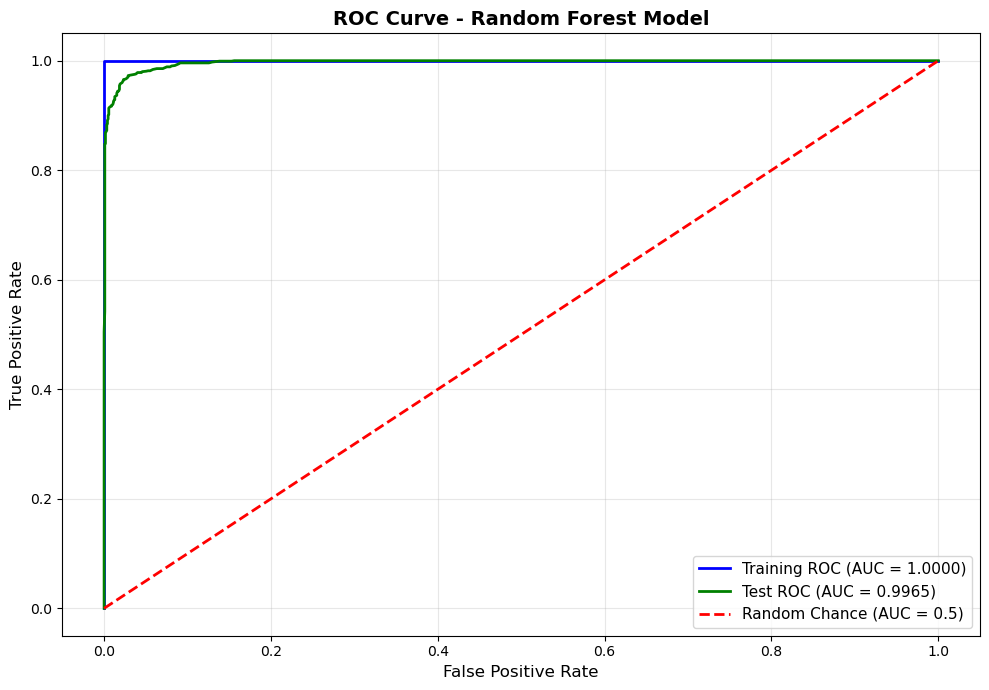

ROC-AUC SCORES
Training AUC: 1.0000
Test AUC:     0.9965


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_train_proba = rf.predict_proba(X_train)[:, 1]
y_test_proba = rf.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

results["baseline_rf"]["train_auc"] = train_auc
results["baseline_rf"]["test_auc"] = test_auc

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {train_auc:.4f})', 
         linewidth=2, color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {test_auc:.4f})', 
         linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance (AUC = 0.5)', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 50)
print("ROC-AUC SCORES")
print("=" * 50)
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC:     {test_auc:.4f}")
print("=" * 50)

## Caliberation Curve

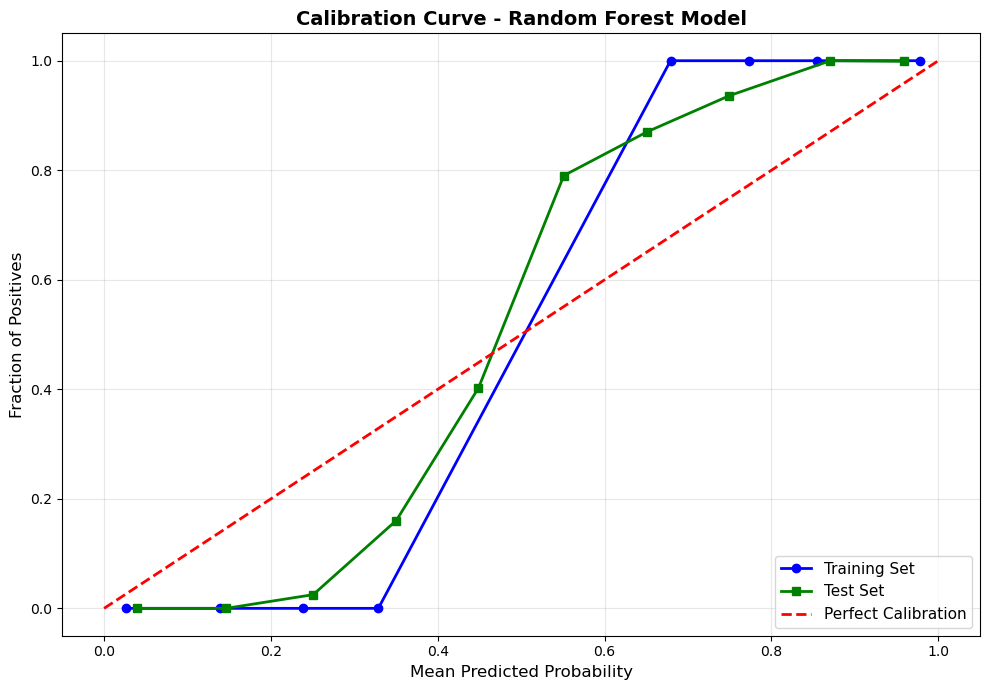

CALIBRATION CURVE ANALYSIS
A well-calibrated model's curve follows the diagonal line.
Points above the line indicate under-confidence.
Points below the line indicate over-confidence.


In [ ]:

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_proba, n_bins=10)
prob_true_test, prob_pred_test = calibration_curve(y_test, y_test_proba, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot(prob_pred_train, prob_true_train, marker='o', linewidth=2, 
         label='Training Set', color='blue')
plt.plot(prob_pred_test, prob_true_test, marker='s', linewidth=2, 
         label='Test Set', color='green')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Curve - Random Forest Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 50)
print("CALIBRATION CURVE ANALYSIS")
print("=" * 50)
print("A well-calibrated model's curve follows the diagonal line.")
print("Points above the line indicate under-confidence.")
print("Points below the line indicate over-confidence.")
print("=" * 50)

## Noise 1 = Symmetric Noise, 10%

Original label distribution: [3750 3750]
Noisy label distribution: [3770 3730]

RANDOM FOREST WITH 10% SYMMETRIC NOISE
Accuracy:  0.9656
Precision: 0.9739
Recall:    0.9568
F1 Score:  0.9653
AUC Score: 0.9962



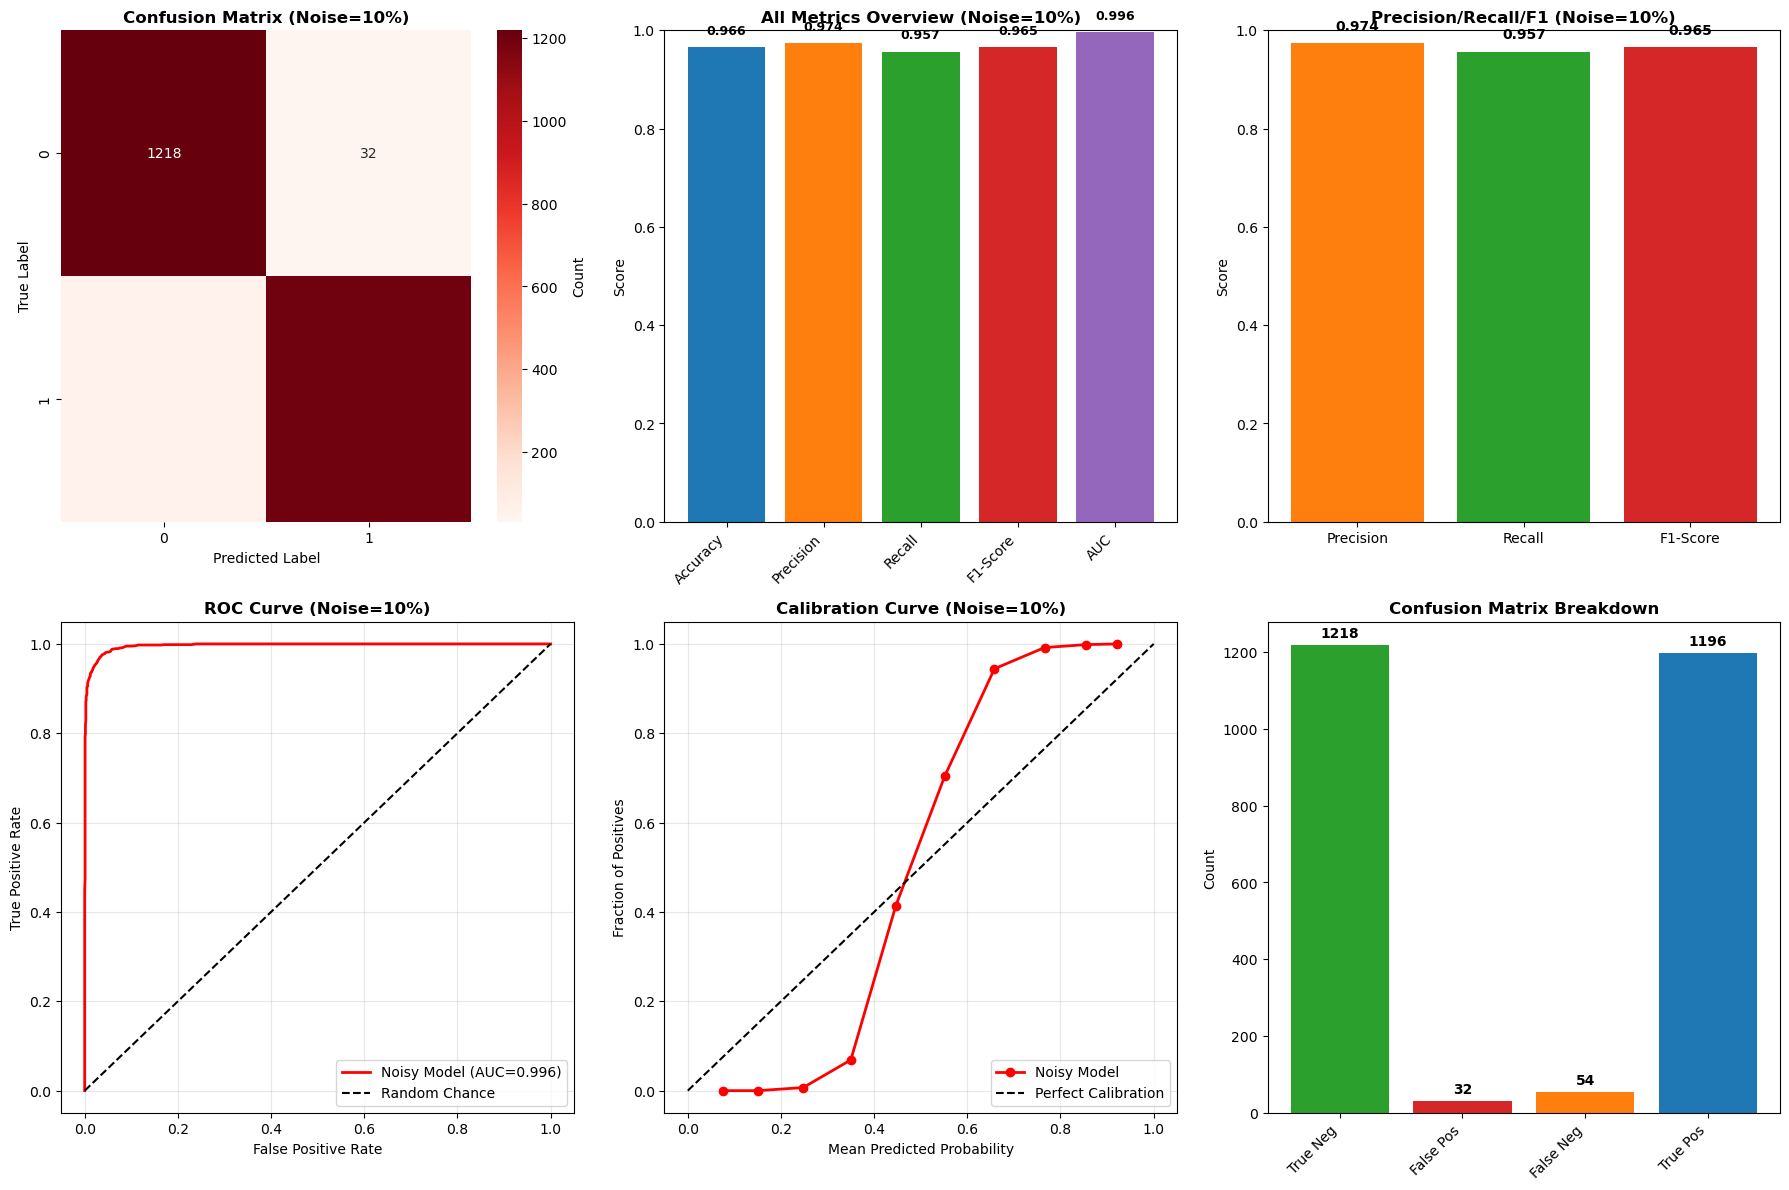


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.97      0.97      1250
     Default       0.97      0.96      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.1
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

# Cell 1

CLEAN ACC, AUC 0.9692 0.9965
NOISY ACC, PREC, REC, F1, AUC 0.5172 0.5213 0.4216 0.4662 0.5188


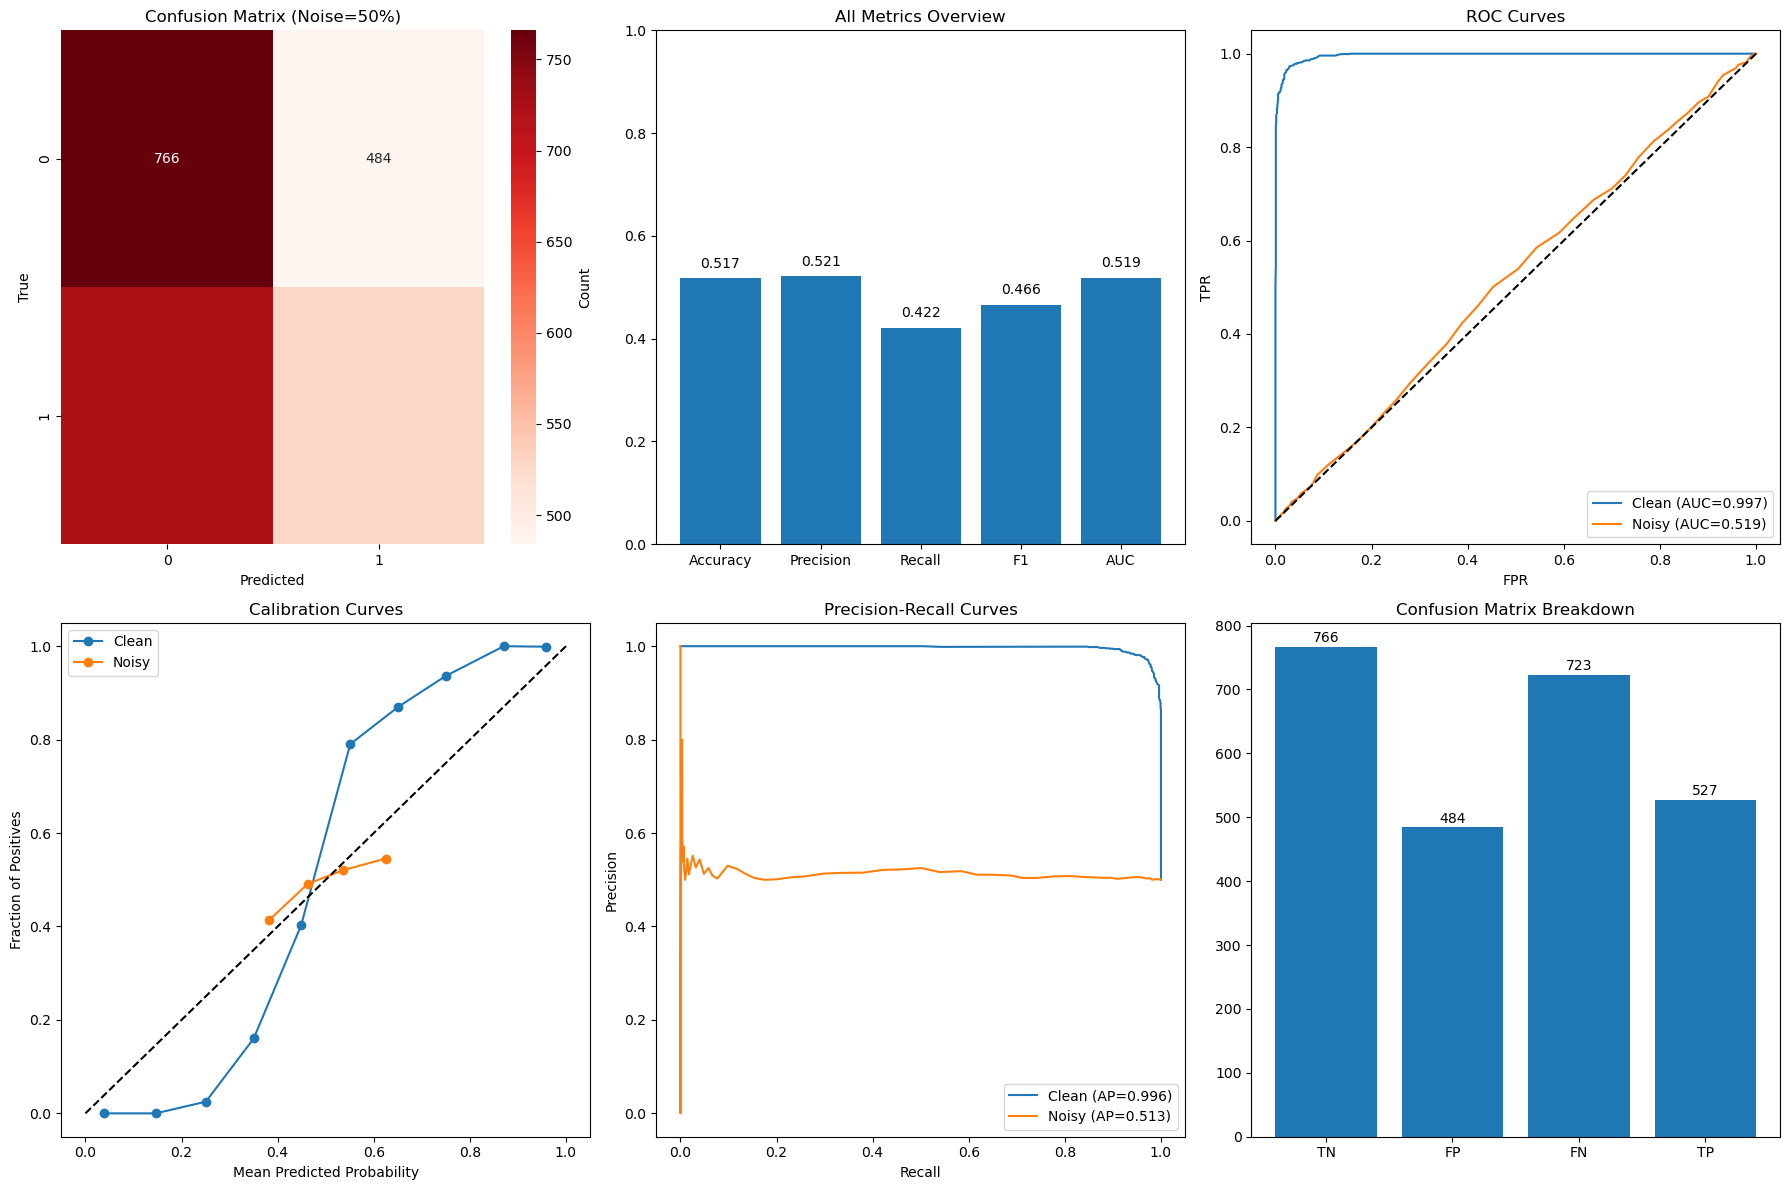


CLASSIFICATION REPORT (Noisy Model)

              precision    recall  f1-score   support

           0       0.51      0.61      0.56      1250
           1       0.52      0.42      0.47      1250

    accuracy                           0.52      2500
   macro avg       0.52      0.52      0.51      2500
weighted avg       0.52      0.52      0.51      2500



In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel, wilcoxon
np.random.seed(42)
p = 0.50
def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy, flip_indices
y_train_noisy, flip_idx = inject_symmetric_noise(y_train.values, noise_rate=p, random_state=42)
rf_clean = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_clean.fit(X_train, y_train)
y_pred_clean = rf_clean.predict(X_test)
y_prob_clean = rf_clean.predict_proba(X_test)[:,1]
acc_clean = accuracy_score(y_test, y_pred_clean)
roc_auc_clean = roc_auc_score(y_test, y_prob_clean)
rf_noisy = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_noisy.fit(X_train, y_train_noisy)
y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:,1]
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)
if "noise_results" not in globals():
    results = {}
else:
    results = globals().get("results", {})
results.setdefault("noise_results", {})["symmetric_0.1"] = {"accuracy": acc_noisy, "precision": precision_noisy, "recall": recall_noisy, "f1": f1_noisy, "auc": auc_noisy}
print("CLEAN ACC, AUC", round(acc_clean,4), round(roc_auc_clean,4))
print("NOISY ACC, PREC, REC, F1, AUC", round(acc_noisy,4), round(precision_noisy,4), round(recall_noisy,4), round(f1_noisy,4), round(auc_noisy,4))
fig = plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label':'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(2,3,2)
metrics_names = ['Accuracy','Precision','Recall','F1','AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
plt.ylim(0,1)
bars = plt.bar(metrics_names, metrics_values)
for bar,val in zip(bars,metrics_values):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.02, f'{val:.3f}', ha='center')
plt.title('All Metrics Overview')
plt.subplot(2,3,3)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
fpr_clean, tpr_clean, _ = roc_curve(y_test, y_prob_clean)
plt.plot(fpr_clean,tpr_clean,label=f'Clean (AUC={roc_auc_clean:.3f})')
plt.plot(fpr_noisy,tpr_noisy,label=f'Noisy (AUC={auc_noisy:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC Curves')
plt.subplot(2,3,4)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
prob_true_clean, prob_pred_clean = calibration_curve(y_test, y_prob_clean, n_bins=10)
plt.plot(prob_pred_clean, prob_true_clean, marker='o', label='Clean')
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', label='Noisy')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curves')
plt.subplot(2,3,5)
precision_clean, recall_clean, _ = precision_recall_curve(y_test, y_prob_clean)
precision_noisy_pr, recall_noisy_pr, _ = precision_recall_curve(y_test, y_prob_noisy)
ap_clean = average_precision_score(y_test, y_prob_clean)
ap_noisy = average_precision_score(y_test, y_prob_noisy)
plt.plot(recall_clean, precision_clean, label=f'Clean (AP={ap_clean:.3f})')
plt.plot(recall_noisy_pr, precision_noisy_pr, label=f'Noisy (AP={ap_noisy:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curves')
plt.subplot(2,3,6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['TN','FP','FN','TP']
conf_values = [tn, fp, fn, tp]
bars = plt.bar(conf_metrics, conf_values)
for bar,val in zip(bars,conf_values):
    plt.text(bar.get_x()+bar.get_width()/2, val+max(conf_values)*0.01, str(val), ha='center')
plt.title('Confusion Matrix Breakdown')
plt.tight_layout()
plt.show()
print("\nCLASSIFICATION REPORT (Noisy Model)\n")
print(classification_report(y_test, y_pred_noisy))

# Cell 2

NOISY: mean acc, std 0.50474 0.014374018227343391
NOISY: mean auc, std 0.50376976 0.01840091672109409
TRAIN ACCS mean,std 1.0 0.0
Error overlap ratio (clean vs noisy on test): 0.4675
Train-Test gap (mean train acc - mean test acc): 0.4953


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


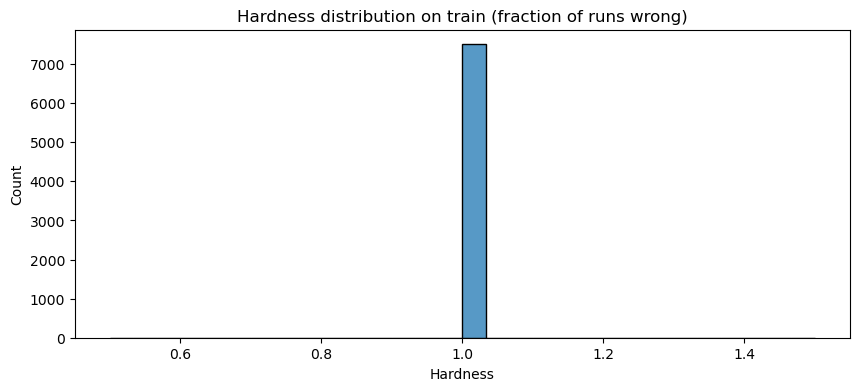

In [53]:
R = 20
accs = []
aucs = []
train_accs = []
flip_masks = []
train_preds_runs = np.zeros((R, X_train.shape[0]), dtype=int)
for r in range(R):
    seed = 100 + r
    y_train_noisy_r, flips_r = inject_symmetric_noise(y_train.values, p, random_state=seed)
    flip_masks.append(flips_r)
    model_r = RandomForestClassifier(n_estimators=200, random_state=seed, n_jobs=-1)
    model_r.fit(X_train, y_train_noisy_r)
    train_preds_runs[r] = model_r.predict(X_train)
    y_pred_r = model_r.predict(X_test)
    y_prob_r = model_r.predict_proba(X_test)[:,1]
    accs.append(accuracy_score(y_test, y_pred_r))
    aucs.append(roc_auc_score(y_test, y_prob_r))
    train_accs.append(accuracy_score(y_train_noisy_r, model_r.predict(X_train)))
accs = np.array(accs)
aucs = np.array(aucs)
train_accs = np.array(train_accs)
print("NOISY: mean acc, std", accs.mean(), accs.std())
print("NOISY: mean auc, std", aucs.mean(), aucs.std())
print("TRAIN ACCS mean,std", train_accs.mean(), train_accs.std())
clean_train_pred = rf_clean.predict(X_train)
hardness = 1 - (train_preds_runs.mean(axis=0) == y_train.values).astype(float)
hardness_series = pd.Series(hardness, index=X_train.index if hasattr(X_train,'index') else np.arange(X_train.shape[0]))
flip_indicator = np.zeros(X_train.shape[0], dtype=int)
flip_indicator[flip_idx] = 1
overlap_indices = set(np.where(rf_clean.predict(X_test) != y_test)[0]) & set(np.where(y_pred_noisy != y_test)[0])
error_overlap_ratio = len(overlap_indices) / max(1, len(np.where(rf_clean.predict(X_test) != y_test)[0]))
print("Error overlap ratio (clean vs noisy on test):", round(error_overlap_ratio,4))
train_gap = train_accs.mean() - accs.mean()
print("Train-Test gap (mean train acc - mean test acc):", round(train_gap,4))
plt.figure(figsize=(10,4))
sns.histplot(hardness, bins=30, kde=False)
plt.title('Hardness distribution on train (fraction of runs wrong)')
plt.xlabel('Hardness')
plt.show()

# Cell 3

Brier clean, noisy 0.0338 0.251
ECE clean, noisy 0.0801 0.0219
MCE clean, noisy 0.2247 0.0792


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


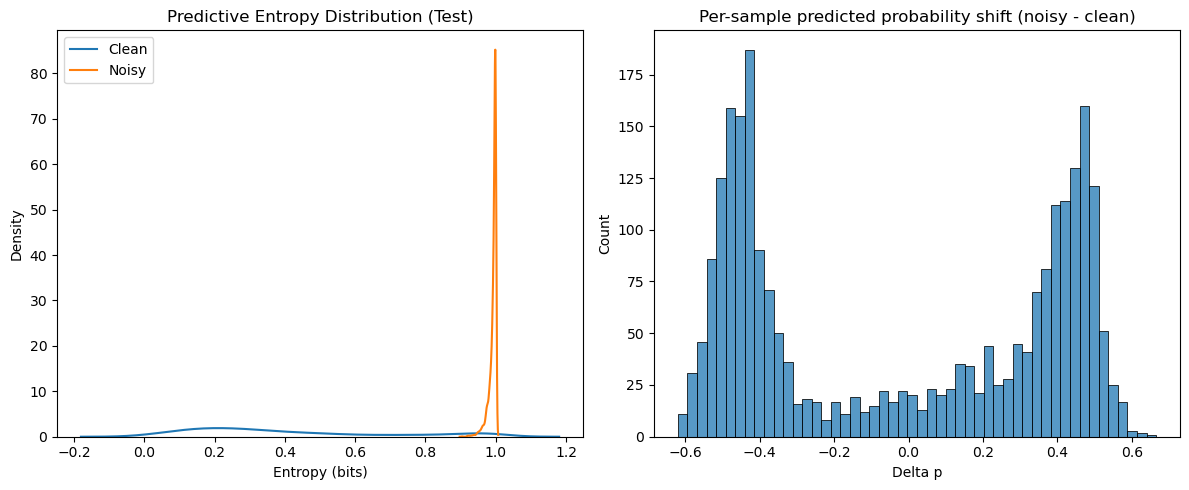

In [54]:
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0,1,n_bins+1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    mce = 0.0
    for i in range(n_bins):
        idx = binids == i
        if idx.sum() == 0:
            continue
        acc = y_true[idx].mean()
        conf = y_prob[idx].mean()
        ece += (idx.sum() / len(y_true)) * abs(acc - conf)
        mce = max(mce, abs(acc - conf))
    return ece, mce
brier_noisy = brier_score_loss(y_test, y_prob_noisy)
ece_noisy, mce_noisy = compute_ece(y_test, y_prob_noisy, n_bins=10)
brier_clean = brier_score_loss(y_test, y_prob_clean)
ece_clean, mce_clean = compute_ece(y_test, y_prob_clean, n_bins=10)
print("Brier clean, noisy", round(brier_clean,4), round(brier_noisy,4))
print("ECE clean, noisy", round(ece_clean,4), round(ece_noisy,4))
print("MCE clean, noisy", round(mce_clean,4), round(mce_noisy,4))
entropy_noisy = -(y_prob_noisy * np.log2(np.clip(y_prob_noisy,1e-12,1-1e-12)) + (1-y_prob_noisy) * np.log2(np.clip(1-y_prob_noisy,1e-12,1-1e-12)))
entropy_clean = -(y_prob_clean * np.log2(np.clip(y_prob_clean,1e-12,1-1e-12)) + (1-y_prob_clean) * np.log2(np.clip(1-y_prob_clean,1e-12,1-1e-12)))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.kdeplot(entropy_clean, label='Clean')
sns.kdeplot(entropy_noisy, label='Noisy')
plt.title('Predictive Entropy Distribution (Test)')
plt.xlabel('Entropy (bits)')
plt.legend()
plt.subplot(1,2,2)
delta_p = y_prob_noisy - y_prob_clean
sns.histplot(delta_p, bins=50)
plt.title('Per-sample predicted probability shift (noisy - clean)')
plt.xlabel('Delta p')
plt.tight_layout()
plt.show()

# Cell 4

Top 10 features that increased importance under noise
                         clean     noisy      diff
earliest_cr_line      0.005349  0.026129  0.020780
zip_code              0.005574  0.025999  0.020425
mo_sin_old_rev_tl_op  0.005770  0.026108  0.020338
emp_title             0.005814  0.026110  0.020296
dti                   0.006210  0.026147  0.019937
mo_sin_old_il_acct    0.005655  0.024842  0.019187
total_bal_ex_mort     0.005279  0.024398  0.019119
revol_bal             0.005492  0.024098  0.018606
avg_cur_bal           0.005735  0.023994  0.018258
revol_util            0.006229  0.024423  0.018194

Top 10 features that decreased importance under noise
                         clean     noisy      diff
total_rec_late_fee    0.009299  0.003453 -0.005846
sub_grade             0.025204  0.017050 -0.008154
debt_settlement_flag  0.014679  0.001579 -0.013100
grade                 0.021216  0.007372 -0.013844
last_credit_pull_d    0.031686  0.015273 -0.016413
total_pymnt           0.

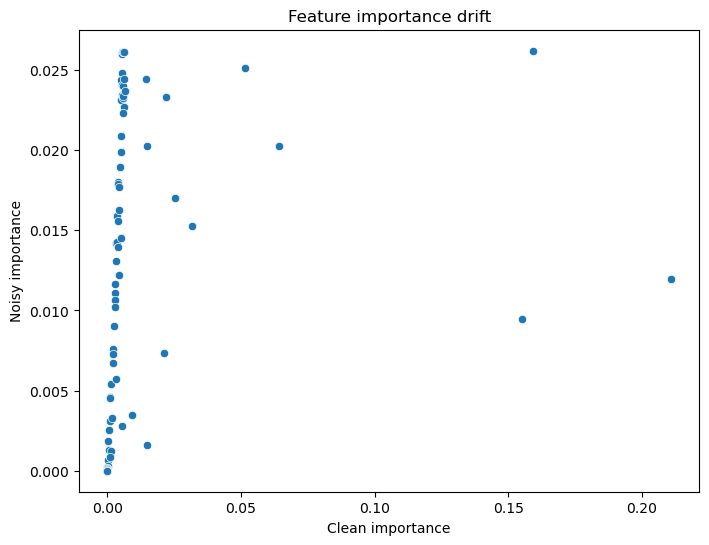

In [55]:
fi_clean = pd.Series(rf_clean.feature_importances_, index=getattr(X_train,'columns', np.arange(X_train.shape[1])))
fi_noisy = pd.Series(rf_noisy.feature_importances_, index=getattr(X_train,'columns', np.arange(X_train.shape[1])))
fi_compare = pd.concat([fi_clean.rename('clean'), fi_noisy.rename('noisy')], axis=1).fillna(0)
fi_compare['diff'] = fi_compare['noisy'] - fi_compare['clean']
fi_compare = fi_compare.sort_values('diff', ascending=False)
print("Top 10 features that increased importance under noise")
print(fi_compare.head(10))
print("\nTop 10 features that decreased importance under noise")
print(fi_compare.tail(10))
perm_noisy = permutation_importance(rf_noisy, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_clean = permutation_importance(rf_clean, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    'feature': getattr(X_test,'columns', np.arange(X_test.shape[1])),
    'perm_clean_mean': perm_clean.importances_mean,
    'perm_noisy_mean': perm_noisy.importances_mean
})
perm_df['diff'] = perm_df['perm_noisy_mean'] - perm_df['perm_clean_mean']
perm_df = perm_df.sort_values('diff', ascending=False)
print("\nPermutation importance differences (top increases):")
print(perm_df.head(10))
rank_corr = fi_compare['clean'].rank().corr(fi_compare['noisy'].rank(), method='spearman')
print("\nSpearman rank correlation between clean and noisy feature importance:", round(rank_corr,4))
plt.figure(figsize=(8,6))
sns.scatterplot(x=fi_compare['clean'], y=fi_compare['noisy'])
plt.xlabel('Clean importance')
plt.ylabel('Noisy importance')
plt.title('Feature importance drift')
plt.show()

# Cell 5

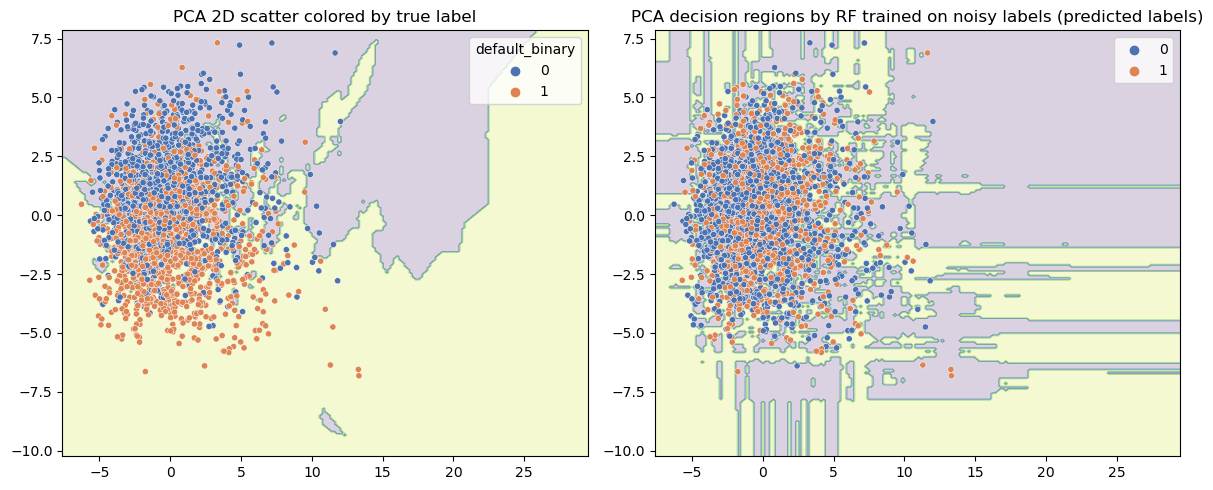

Cluster purity mean before noise: 0.648616876621598
Cluster purity mean after noise: 0.5195299350815425
Mean local purity clean vs noisy 0.7073777777777779 0.5005037037037037


In [56]:
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform((X_train if isinstance(X_train, np.ndarray) else X_train.values))
X_test_2d = pca.transform((X_test if isinstance(X_test, np.ndarray) else X_test.values))
xx_min, xx_max = X_train_2d[:,0].min()-0.5, X_train_2d[:,0].max()+0.5
yy_min, yy_max = X_train_2d[:,1].min()-0.5, X_train_2d[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 200), np.linspace(yy_min, yy_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
from sklearn.neighbors import KNeighborsClassifier
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_2d, y_train)
grid_pred_clean = knn_pca.predict(grid)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(xx, yy, grid_pred_clean.reshape(xx.shape), alpha=0.2)
sns.scatterplot(x=X_test_2d[:,0], y=X_test_2d[:,1], hue=y_test, palette='deep', s=20)
plt.title('PCA 2D scatter colored by true label')
plt.subplot(1,2,2)
rf_noisy_on_pca = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_noisy_on_pca.fit(X_train_2d, y_train_noisy)
grid_pred_rf = rf_noisy_on_pca.predict(grid)
plt.contourf(xx, yy, grid_pred_rf.reshape(xx.shape), alpha=0.2)
sns.scatterplot(x=X_test_2d[:,0], y=X_test_2d[:,1], hue=y_pred_noisy, palette='deep', s=20)
plt.title('PCA decision regions by RF trained on noisy labels (predicted labels)')
plt.tight_layout()
plt.show()
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_train if isinstance(X_train, np.ndarray) else X_train.values)
clusters = kmeans.labels_
cluster_purity = []
for c in np.unique(clusters):
    idx = np.where(clusters==c)[0]
    purity = np.bincount(y_train.values[idx]).max() / max(1, len(idx))
    cluster_purity.append(purity)
print("Cluster purity mean before noise:", np.mean(cluster_purity))
y_train_noisy_series = pd.Series(y_train_noisy, index=(X_train.index if hasattr(X_train,'index') else np.arange(X_train.shape[0])))
cluster_purity_noisy = []
for c in np.unique(clusters):
    idx = np.where(clusters==c)[0]
    purity = np.bincount(y_train_noisy[idx]).max() / max(1, len(idx))
    cluster_purity_noisy.append(purity)
print("Cluster purity mean after noise:", np.mean(cluster_purity_noisy))
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=10).fit((X_train if isinstance(X_train, np.ndarray) else X_train.values))
distances, indices = nn.kneighbors((X_train if isinstance(X_train, np.ndarray) else X_train.values))
local_purity_clean = []
local_purity_noisy = []
for i in range(X_train.shape[0]):
    neigh_idx = indices[i,1:]
    local_purity_clean.append((y_train.values[neigh_idx] == y_train.values[i]).mean())
    local_purity_noisy.append((y_train_noisy[neigh_idx] == y_train_noisy[i]).mean())
print("Mean local purity clean vs noisy", np.mean(local_purity_clean), np.mean(local_purity_noisy))

# Cell 6

In [57]:
def bootstrap_ci(data, n_boot=2000, alpha=0.05):
    boot_means = []
    n = len(data)
    rng = np.random.RandomState(42)
    for _ in range(n_boot):
        sample = rng.choice(data, size=n, replace=True)
        boot_means.append(sample.mean())
    lo = np.percentile(boot_means, 100*alpha/2)
    hi = np.percentile(boot_means, 100*(1-alpha/2))
    return lo, hi
clean_scores = []
noisy_scores = accs
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in skf.split(X_train, y_train):
    model_cv = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    model_cv.fit(X_train.iloc[train_idx] if hasattr(X_train,'iloc') else X_train[train_idx], y_train.values[train_idx])
    preds_cv = model_cv.predict(X_train.iloc[test_idx] if hasattr(X_train,'iloc') else X_train[test_idx])
    clean_scores.append(accuracy_score(y_train.values[test_idx], preds_cv))
clean_scores = np.array(clean_scores)
print("CV acc clean mean,std", clean_scores.mean(), clean_scores.std())
t_stat, p_val = ttest_rel(np.repeat(acc_clean, R), accs)
print("Paired t-test between clean acc and noisy acc across runs t,p", round(t_stat,4), round(p_val,6))
wil_stat, wil_p = wilcoxon(np.repeat(acc_clean, R), accs)
print("Wilcoxon signed-rank p", round(wil_p,6))
acc_lo, acc_hi = bootstrap_ci(accs)
auc_lo, auc_hi = bootstrap_ci(aucs)
print("Bootstrap CI for noisy acc", round(acc_lo,4), round(acc_hi,4))
print("Bootstrap CI for noisy auc", round(auc_lo,4), round(auc_hi,4))
robustness_index = accs.mean() / acc_clean if acc_clean!=0 else np.nan
print("Robustness index (mean noisy acc / clean acc)", round(robustness_index,4))

CV acc clean mean,std 0.96 0.005215361924162121
Paired t-test between clean acc and noisy acc across runs t,p 140.8468 0.0
Wilcoxon signed-rank p 2e-06
Bootstrap CI for noisy acc 0.4984 0.5112
Bootstrap CI for noisy auc 0.4956 0.5121
Robustness index (mean noisy acc / clean acc) 0.5208


## Noise 1 = Symmetric Noise, 20%

Original label distribution: [3750 3750]
Noisy label distribution: [3752 3748]

RANDOM FOREST WITH 20% SYMMETRIC NOISE
Accuracy:  0.9616
Precision: 0.9769
Recall:    0.9456
F1 Score:  0.9610
AUC Score: 0.9952



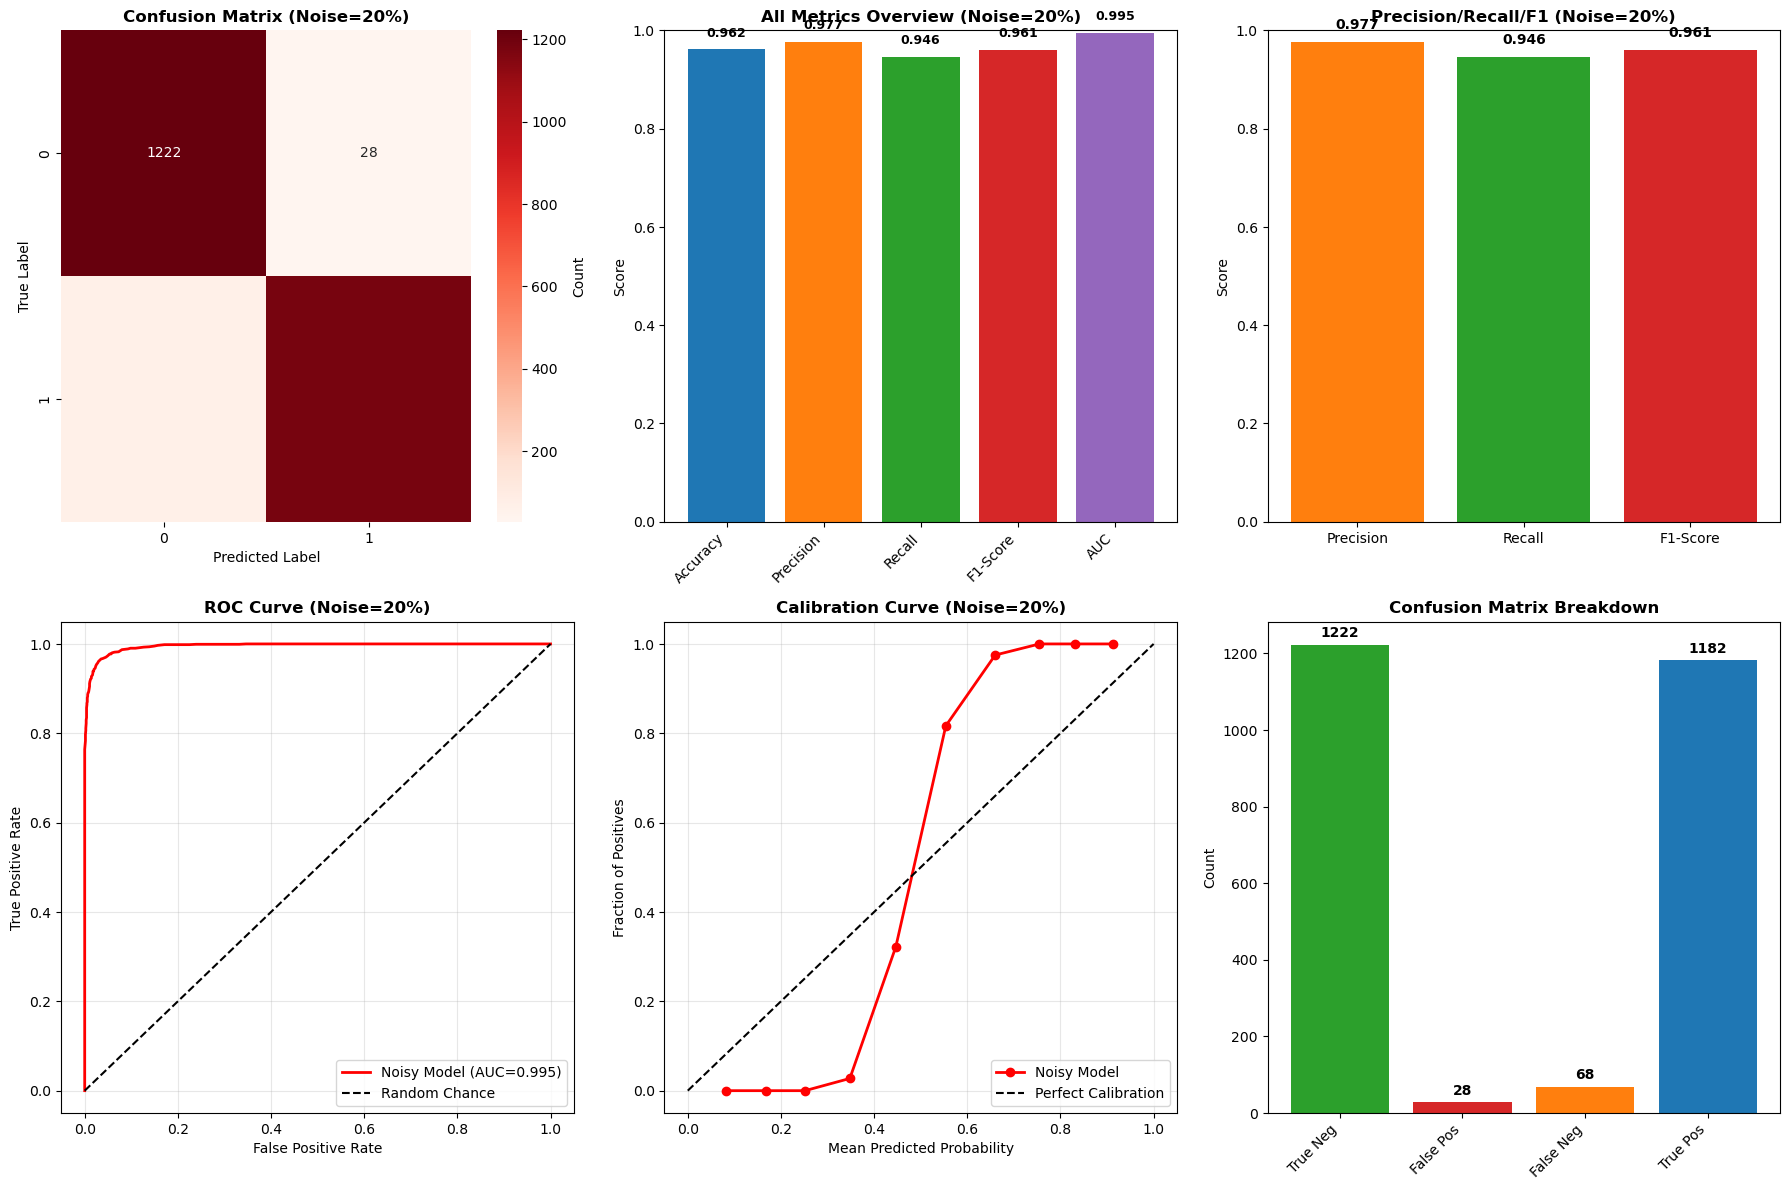


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.95      0.98      0.96      1250
     Default       0.98      0.95      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.20
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 1 = Symmetric Noise, 33%

Original label distribution: [3750 3750]
Noisy label distribution: [3743 3757]

RANDOM FOREST WITH 33% SYMMETRIC NOISE
Accuracy:  0.9368
Precision: 0.9527
Recall:    0.9192
F1 Score:  0.9357
AUC Score: 0.9823



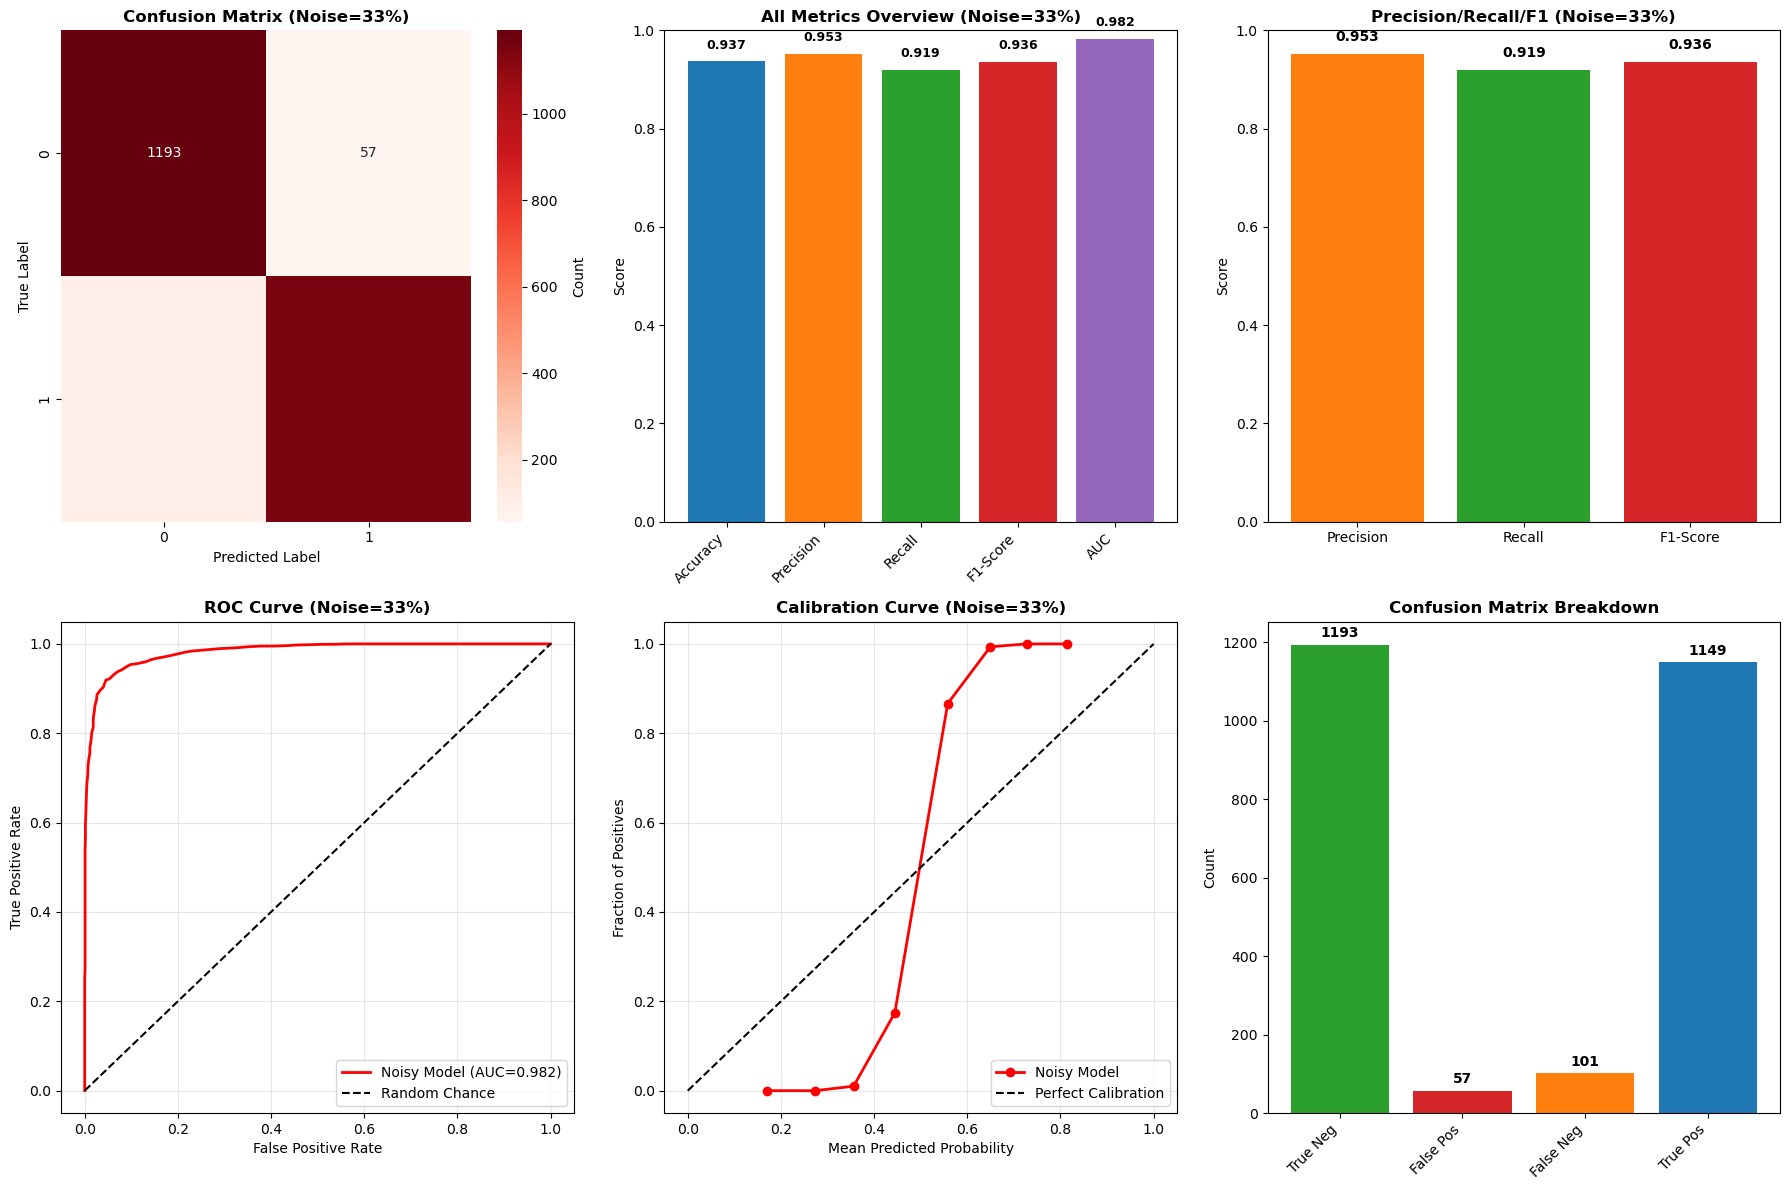


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.92      0.95      0.94      1250
     Default       0.95      0.92      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.33
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 1 = Symmetric Noise, 50%

Original label distribution: [3750 3750]
Noisy label distribution: [3826 3674]

RANDOM FOREST WITH 50% SYMMETRIC NOISE
Accuracy:  0.5172
Precision: 0.5213
Recall:    0.4216
F1 Score:  0.4662
AUC Score: 0.5188



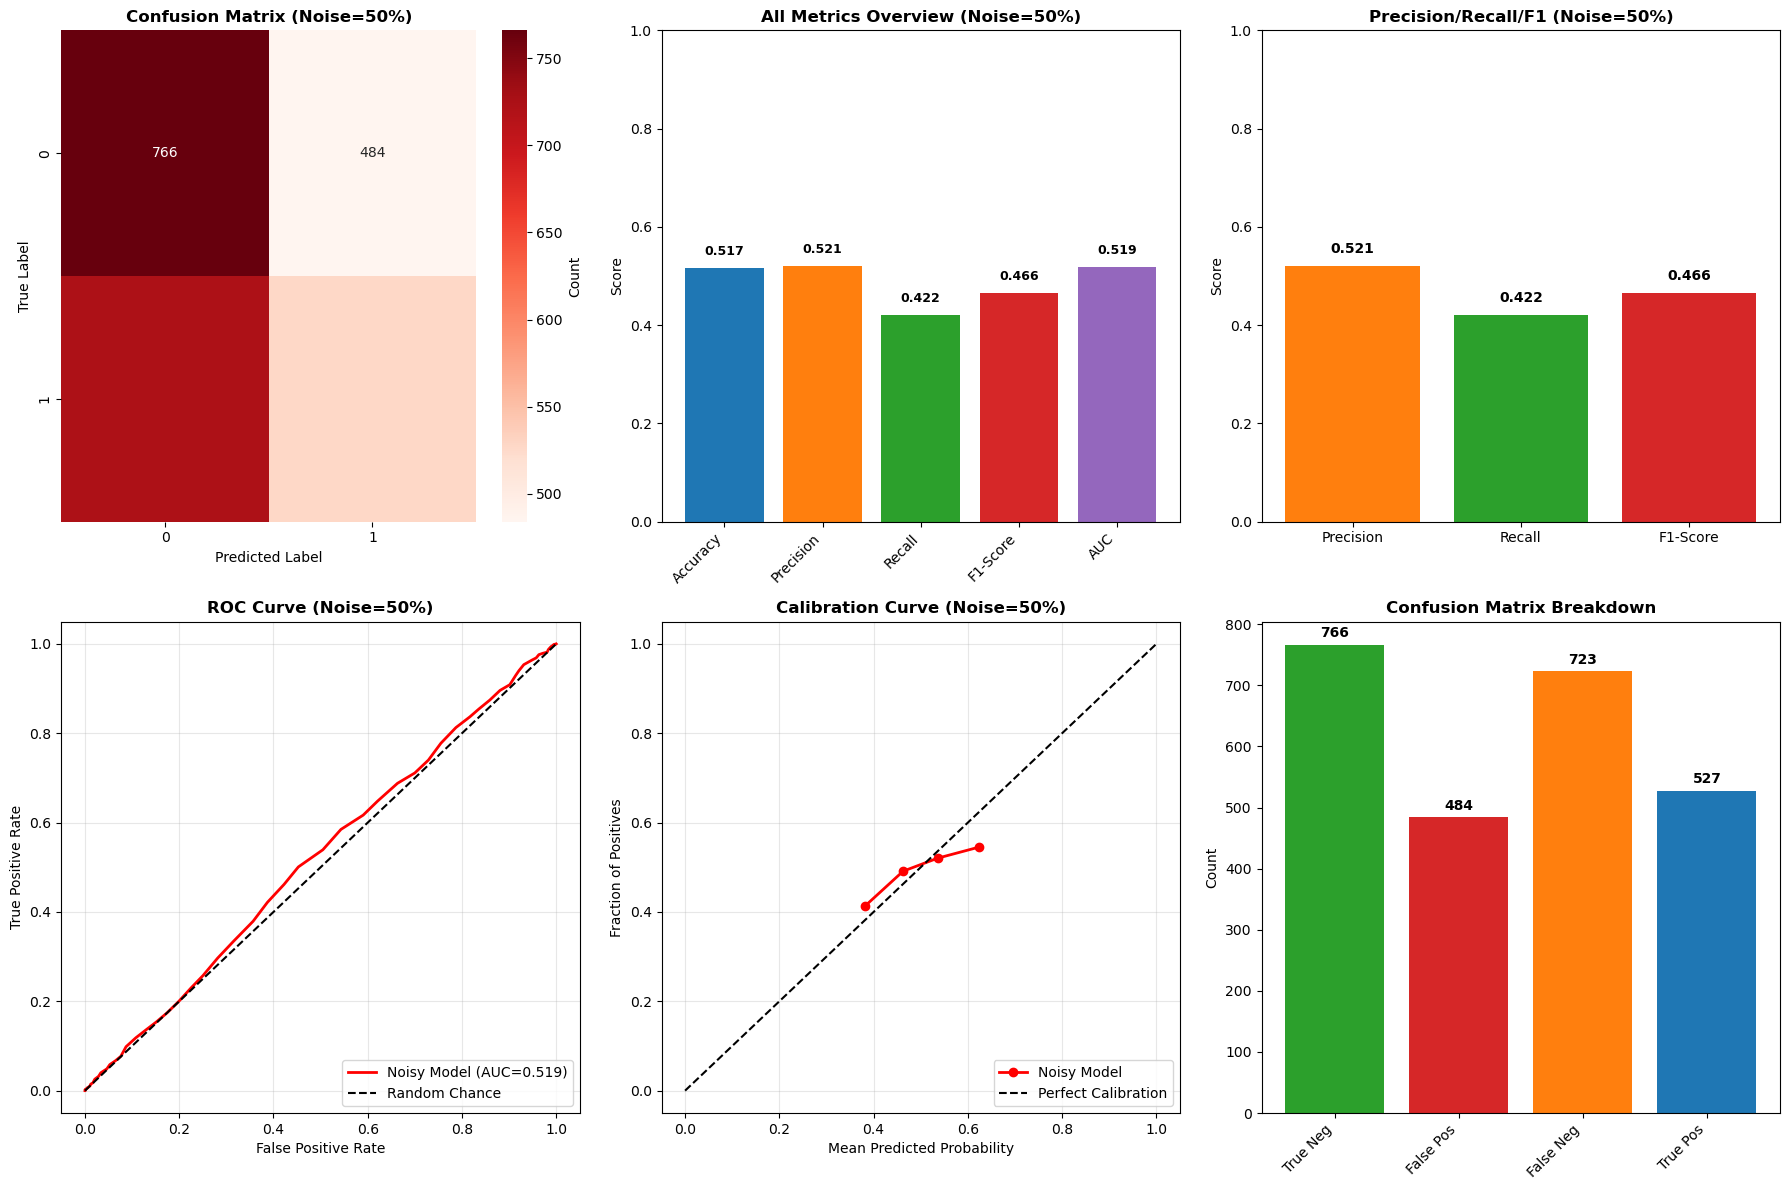


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.51      0.61      0.56      1250
     Default       0.52      0.42      0.47      1250

    accuracy                           0.52      2500
   macro avg       0.52      0.52      0.51      2500
weighted avg       0.52      0.52      0.51      2500



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.50
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

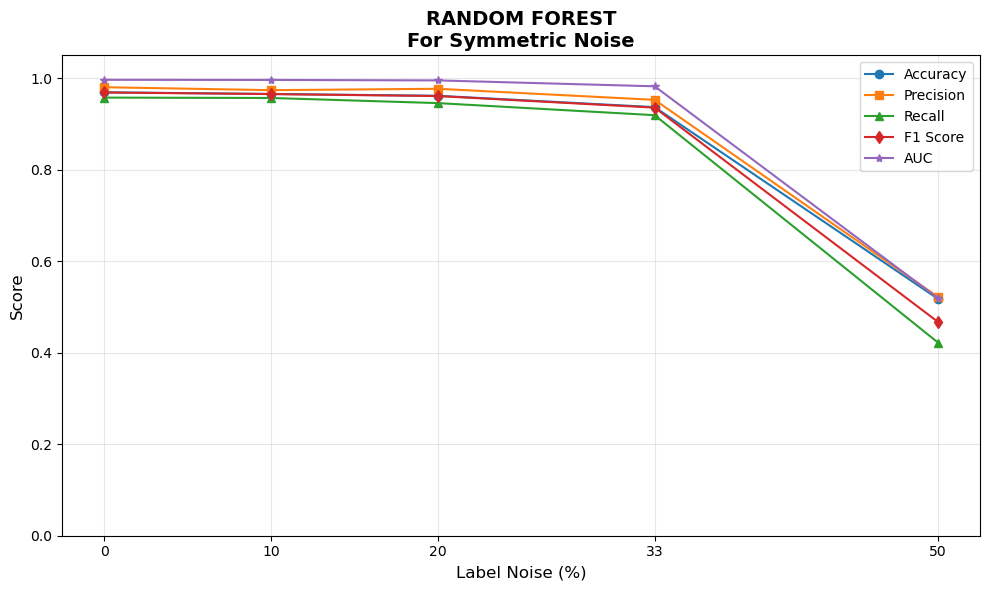

In [58]:
import matplotlib.pyplot as plt

label_noise = [0, 10, 20, 33, 50]
accuracy = [0.9692, 0.9656, 0.9616, 0.9368, 0.5172]
precision = [0.9803, 0.9739, 0.9769, 0.9527, 0.5213]
recall = [0.9576, 0.9568, 0.9456, 0.9192, 0.4216]
f1_score = [0.9688, 0.9653, 0.9610, 0.9357, 0.4668]
auc = [0.9965, 0.9962, 0.9952, 0.9823, 0.5188]

plt.figure(figsize=(10, 6))
plt.plot(label_noise, accuracy, marker='o', label='Accuracy')
plt.plot(label_noise, precision, marker='s', label='Precision')
plt.plot(label_noise, recall, marker='^', label='Recall')
plt.plot(label_noise, f1_score, marker='d', label='F1 Score')
plt.plot(label_noise, auc, marker='*', label='AUC')

plt.xlabel('Label Noise (%)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('RANDOM FOREST\nFor Symmetric Noise', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(label_noise)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

## Noise 2 = Asymmetric Noise, 0 to 1, 10%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3375 4125]
Flipped class 0 -> 1 at rate 0.1

RANDOM FOREST WITH 10% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.9628
Precision: 0.9566
Recall:    0.9696
F1 Score:  0.9631
AUC Score: 0.9960



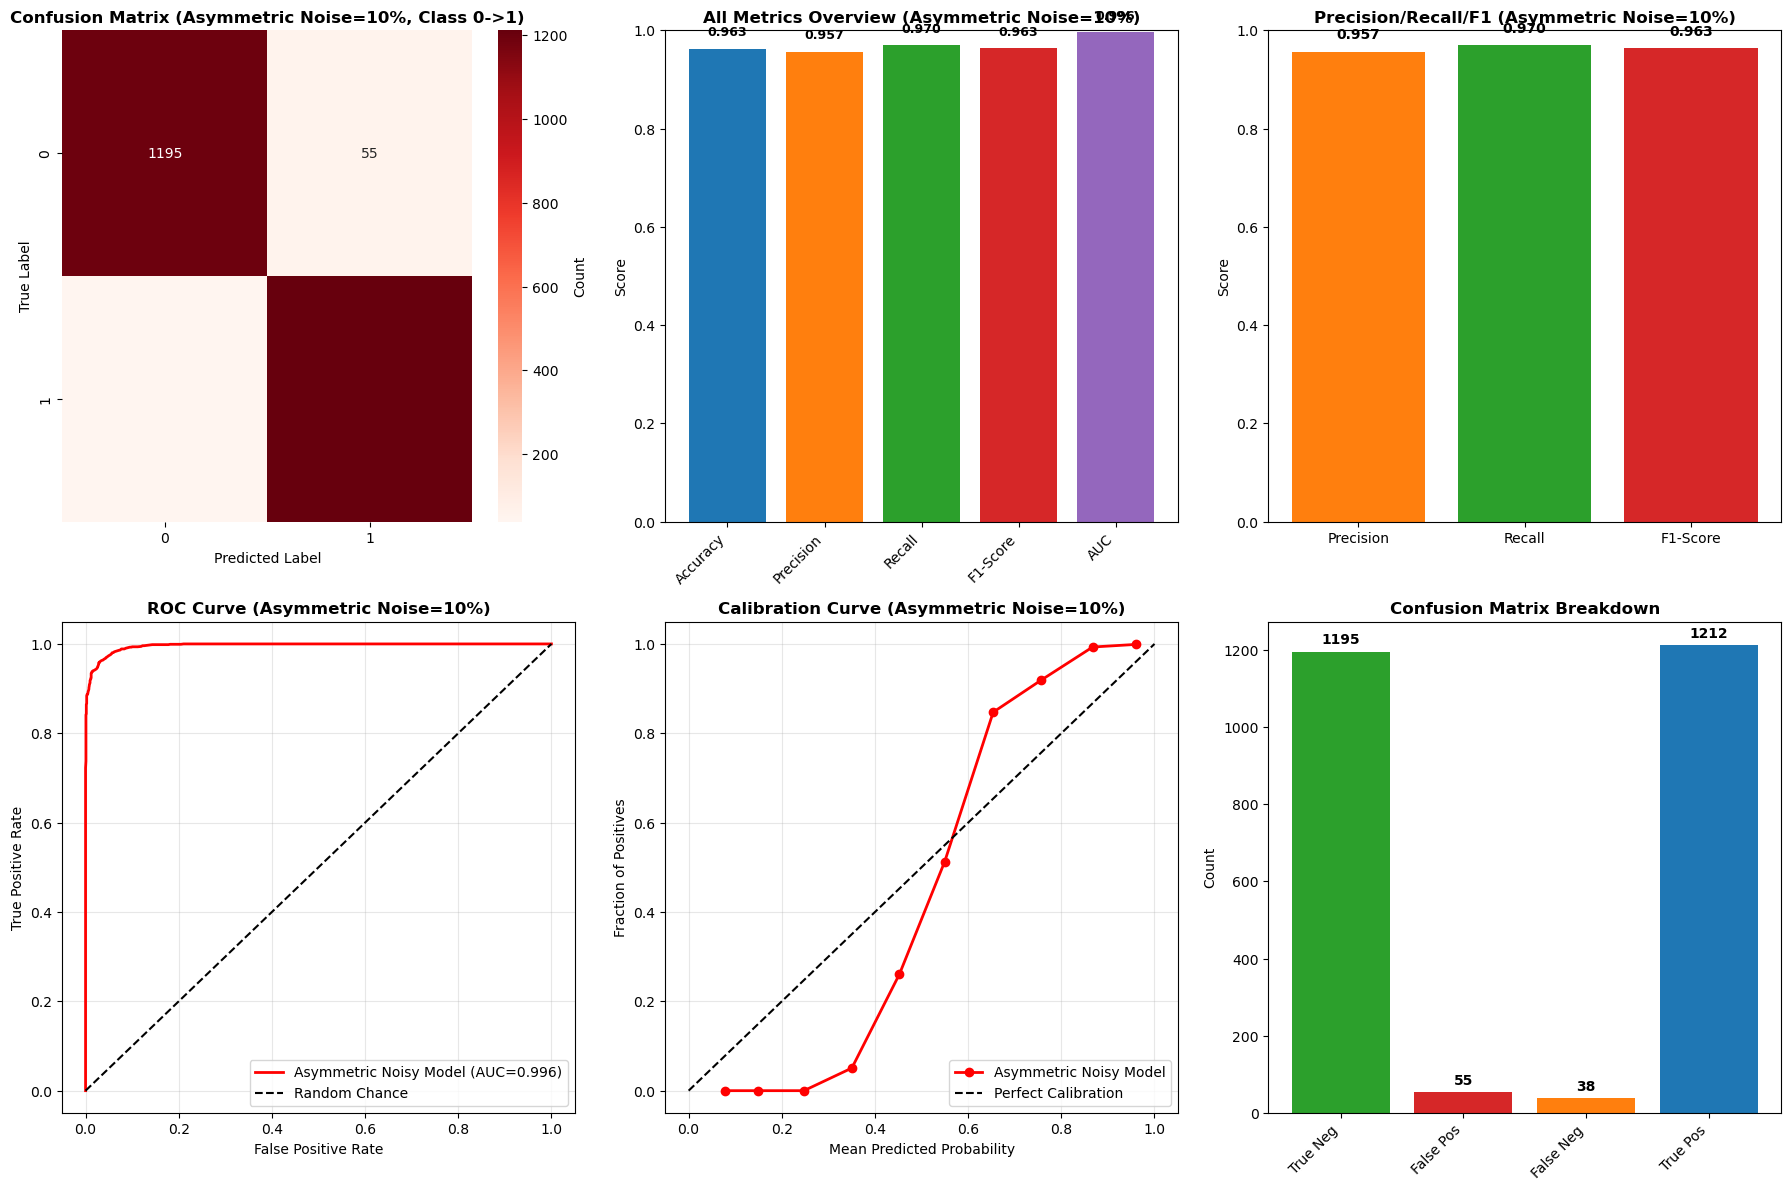


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.97      0.96      1233
     Default       0.97      0.96      0.96      1267

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 0
p = 0.10


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 0 to 1, 20%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3000 4500]
Flipped class 0 -> 1 at rate 0.2

RANDOM FOREST WITH 20% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.9496
Precision: 0.9188
Recall:    0.9864
F1 Score:  0.9514
AUC Score: 0.9955



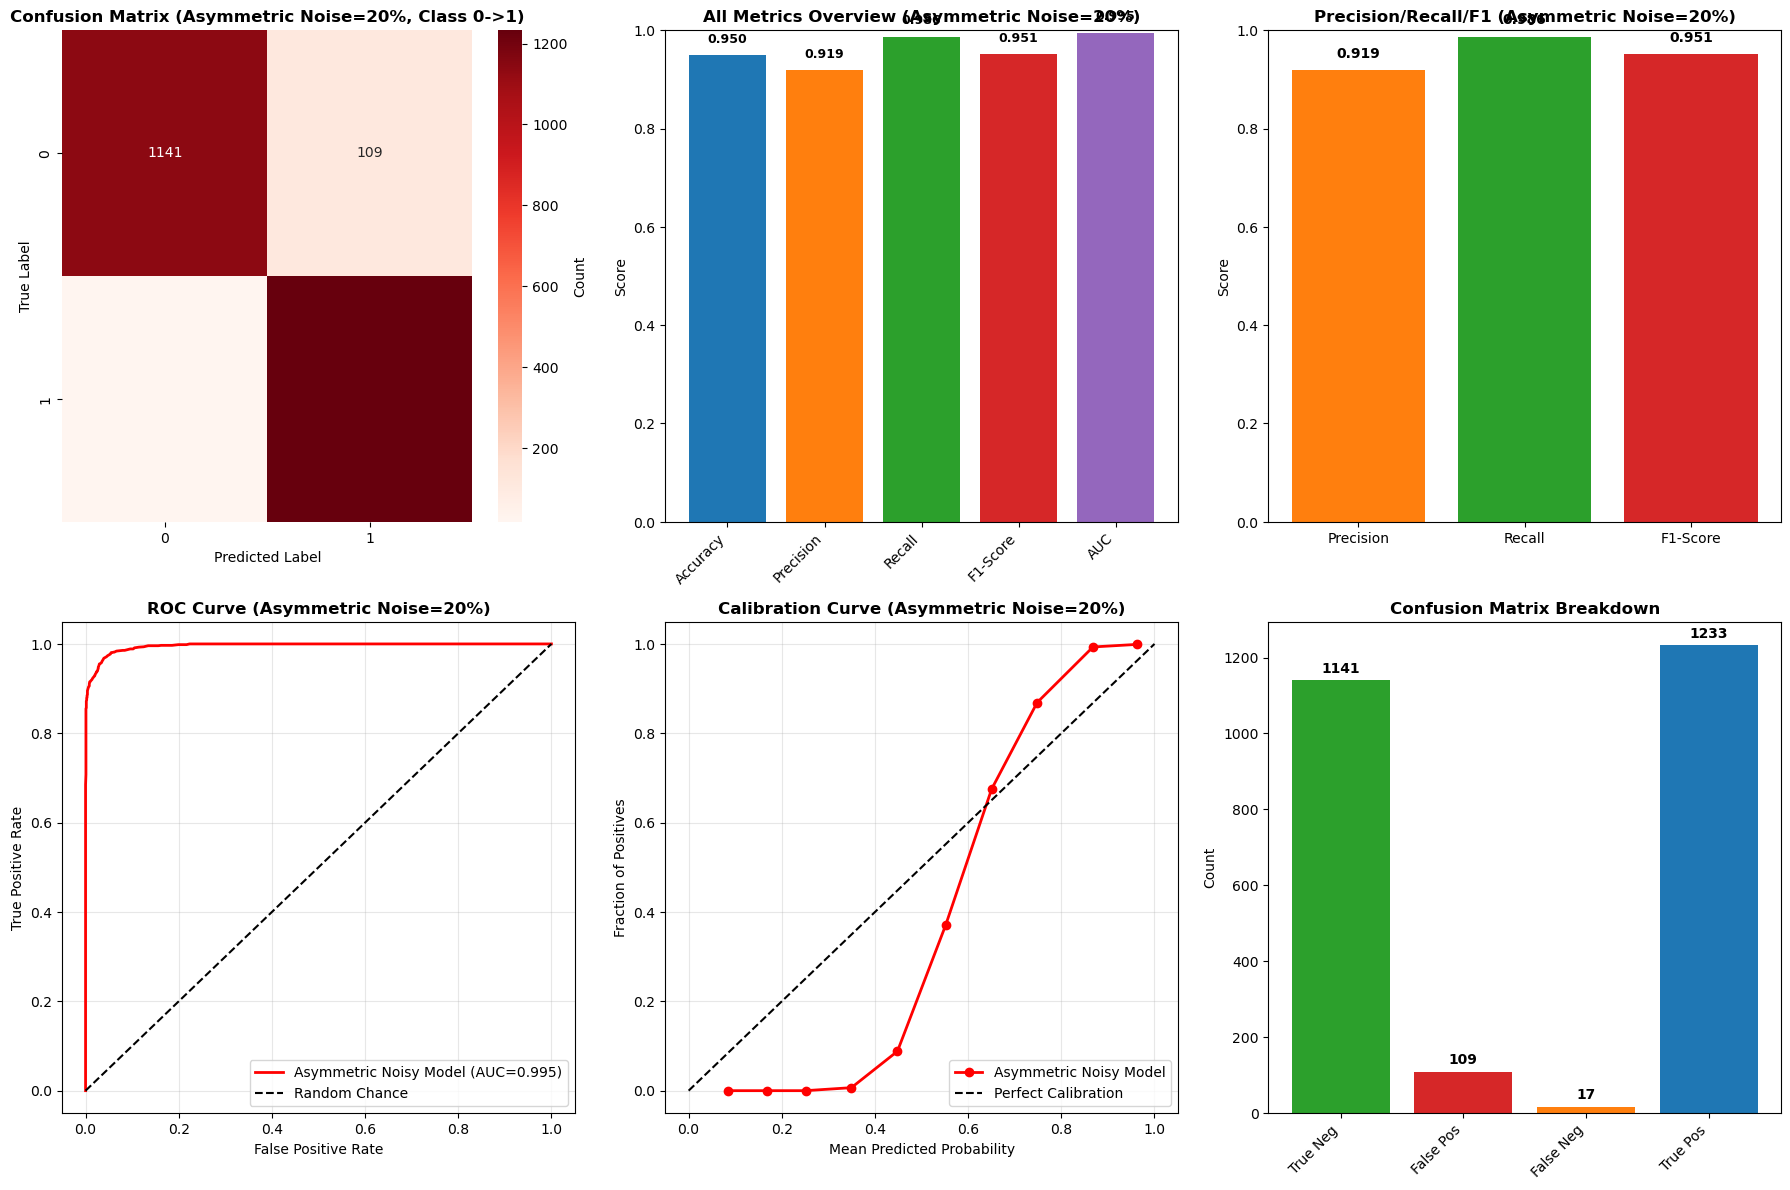


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.91      0.99      0.95      1158
     Default       0.99      0.92      0.95      1342

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 0
p = 0.20


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 0 to 1, 33%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [2513 4987]
Flipped class 0 -> 1 at rate 0.33

RANDOM FOREST WITH 33% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.8960
Precision: 0.8287
Recall:    0.9984
F1 Score:  0.9057
AUC Score: 0.9953



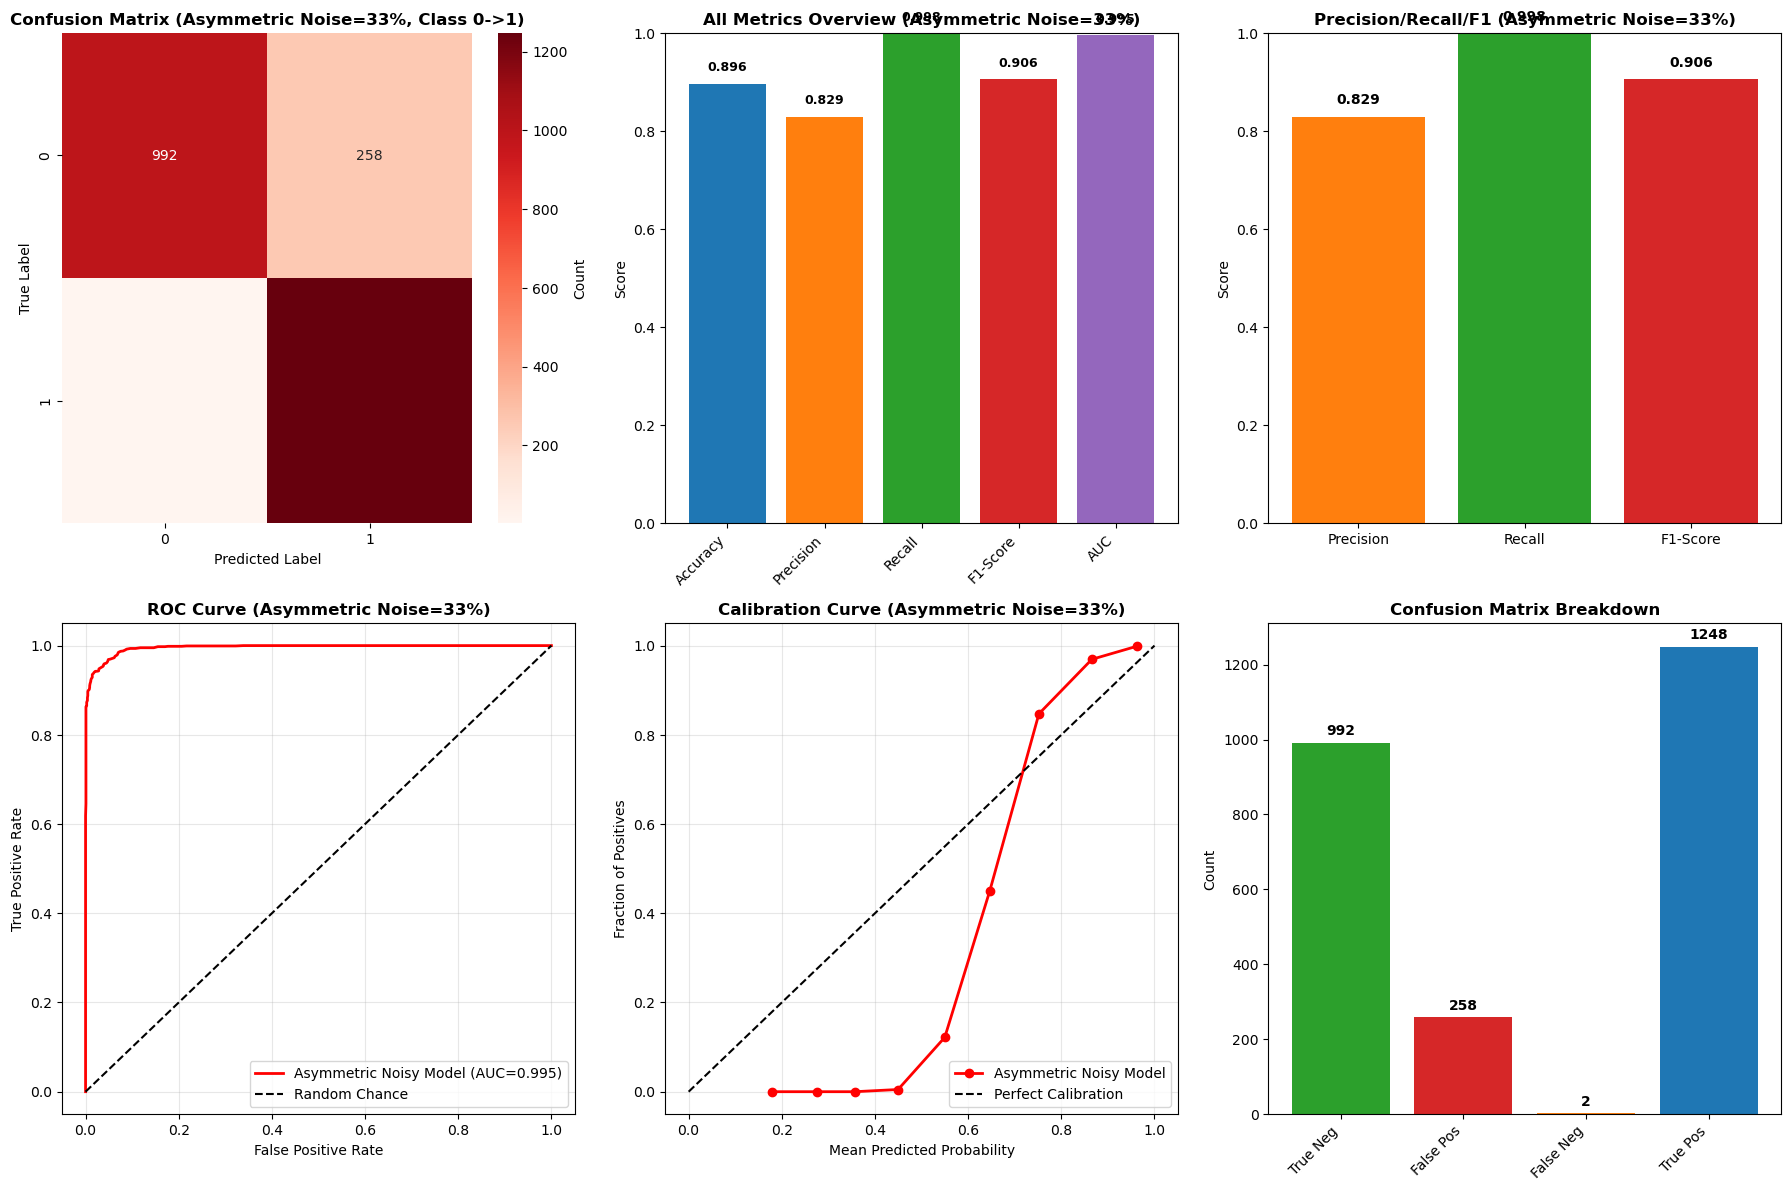


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.79      1.00      0.88       994
     Default       1.00      0.83      0.91      1506

    accuracy                           0.90      2500
   macro avg       0.90      0.91      0.89      2500
weighted avg       0.92      0.90      0.90      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 0
p = 0.33


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 0 to 1, 50%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [1875 5625]
Flipped class 0 -> 1 at rate 0.5

RANDOM FOREST WITH 50% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.6272
Precision: 0.5729
Recall:    1.0000
F1 Score:  0.7284
AUC Score: 0.9908



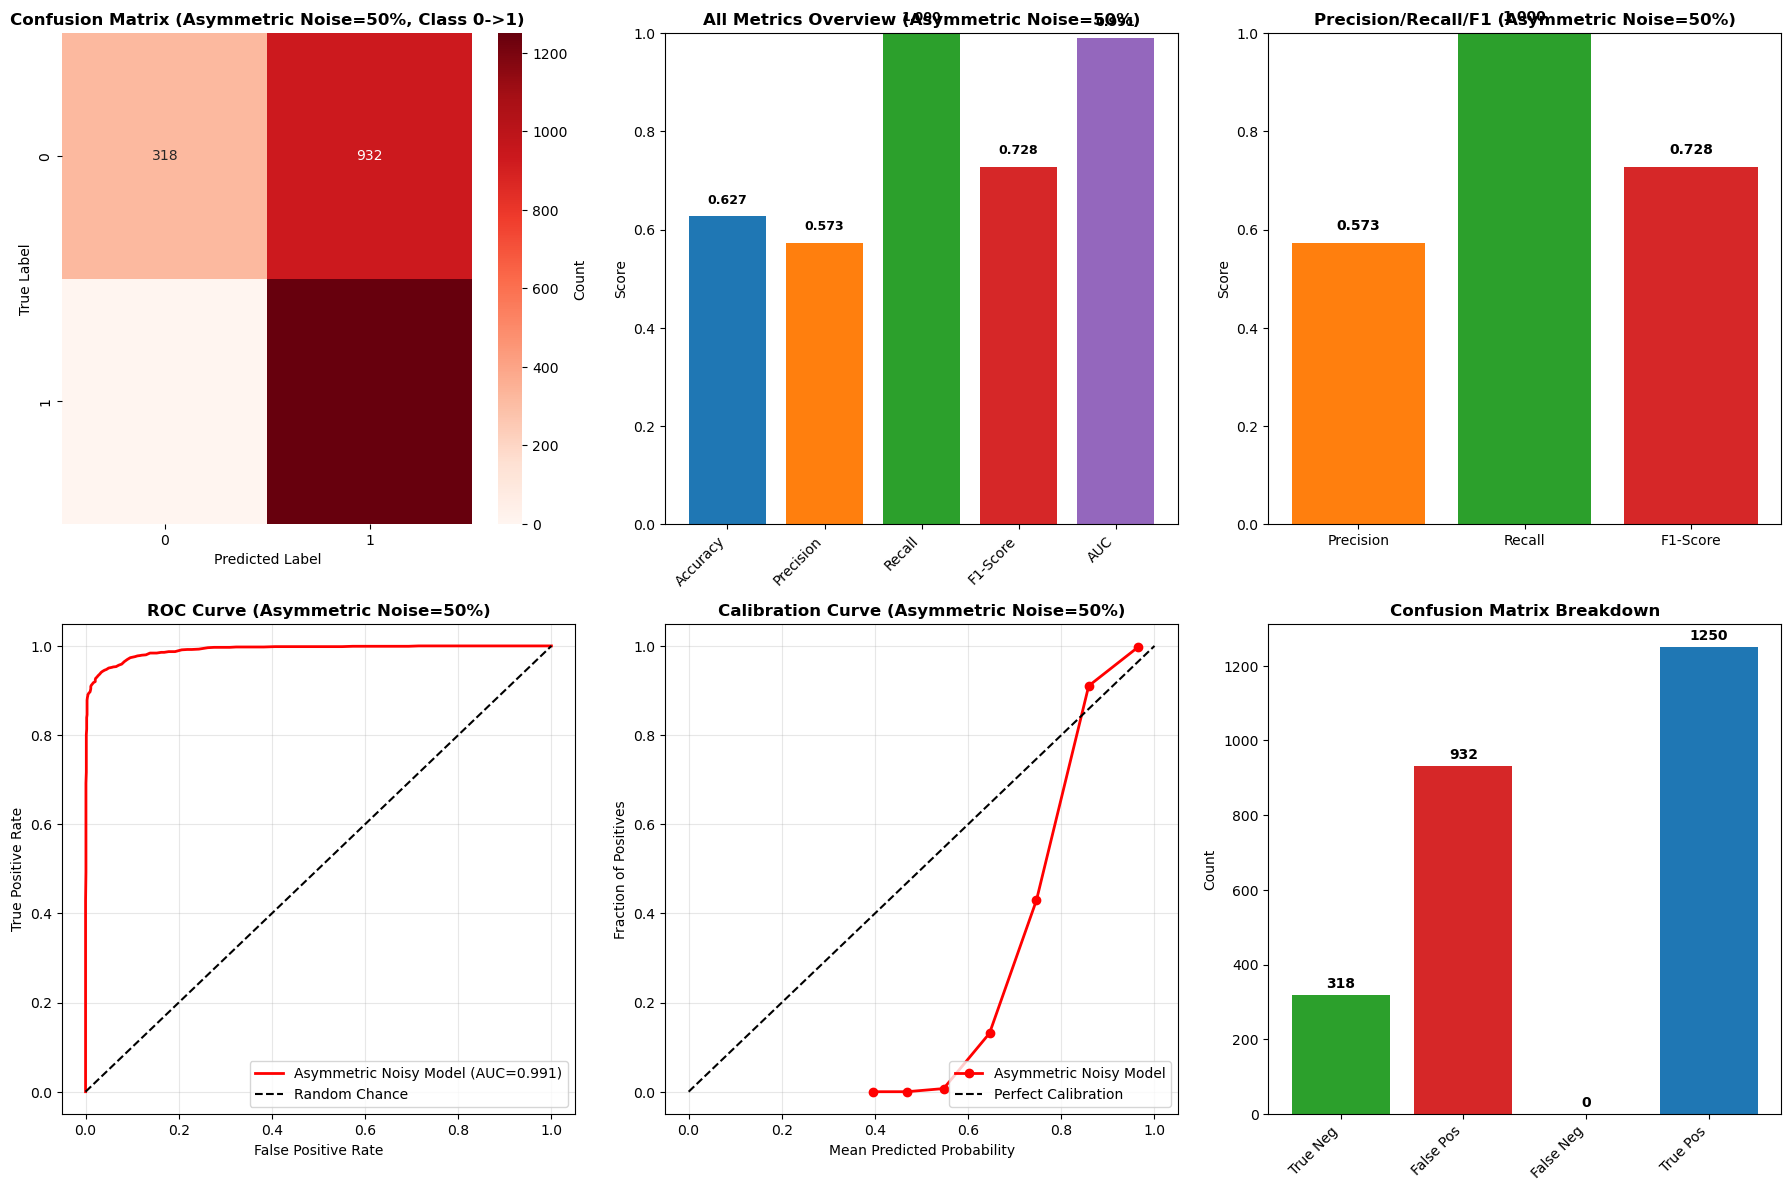


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.25      1.00      0.41       318
     Default       1.00      0.57      0.73      2182

    accuracy                           0.63      2500
   macro avg       0.63      0.79      0.57      2500
weighted avg       0.91      0.63      0.69      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 0
p = 0.50


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 10%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4125 3375]
Flipped class 1 -> 0 at rate 0.1

RANDOM FOREST WITH 10% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.9632
Precision: 0.9907
Recall:    0.9352
F1 Score:  0.9621
AUC Score: 0.9969



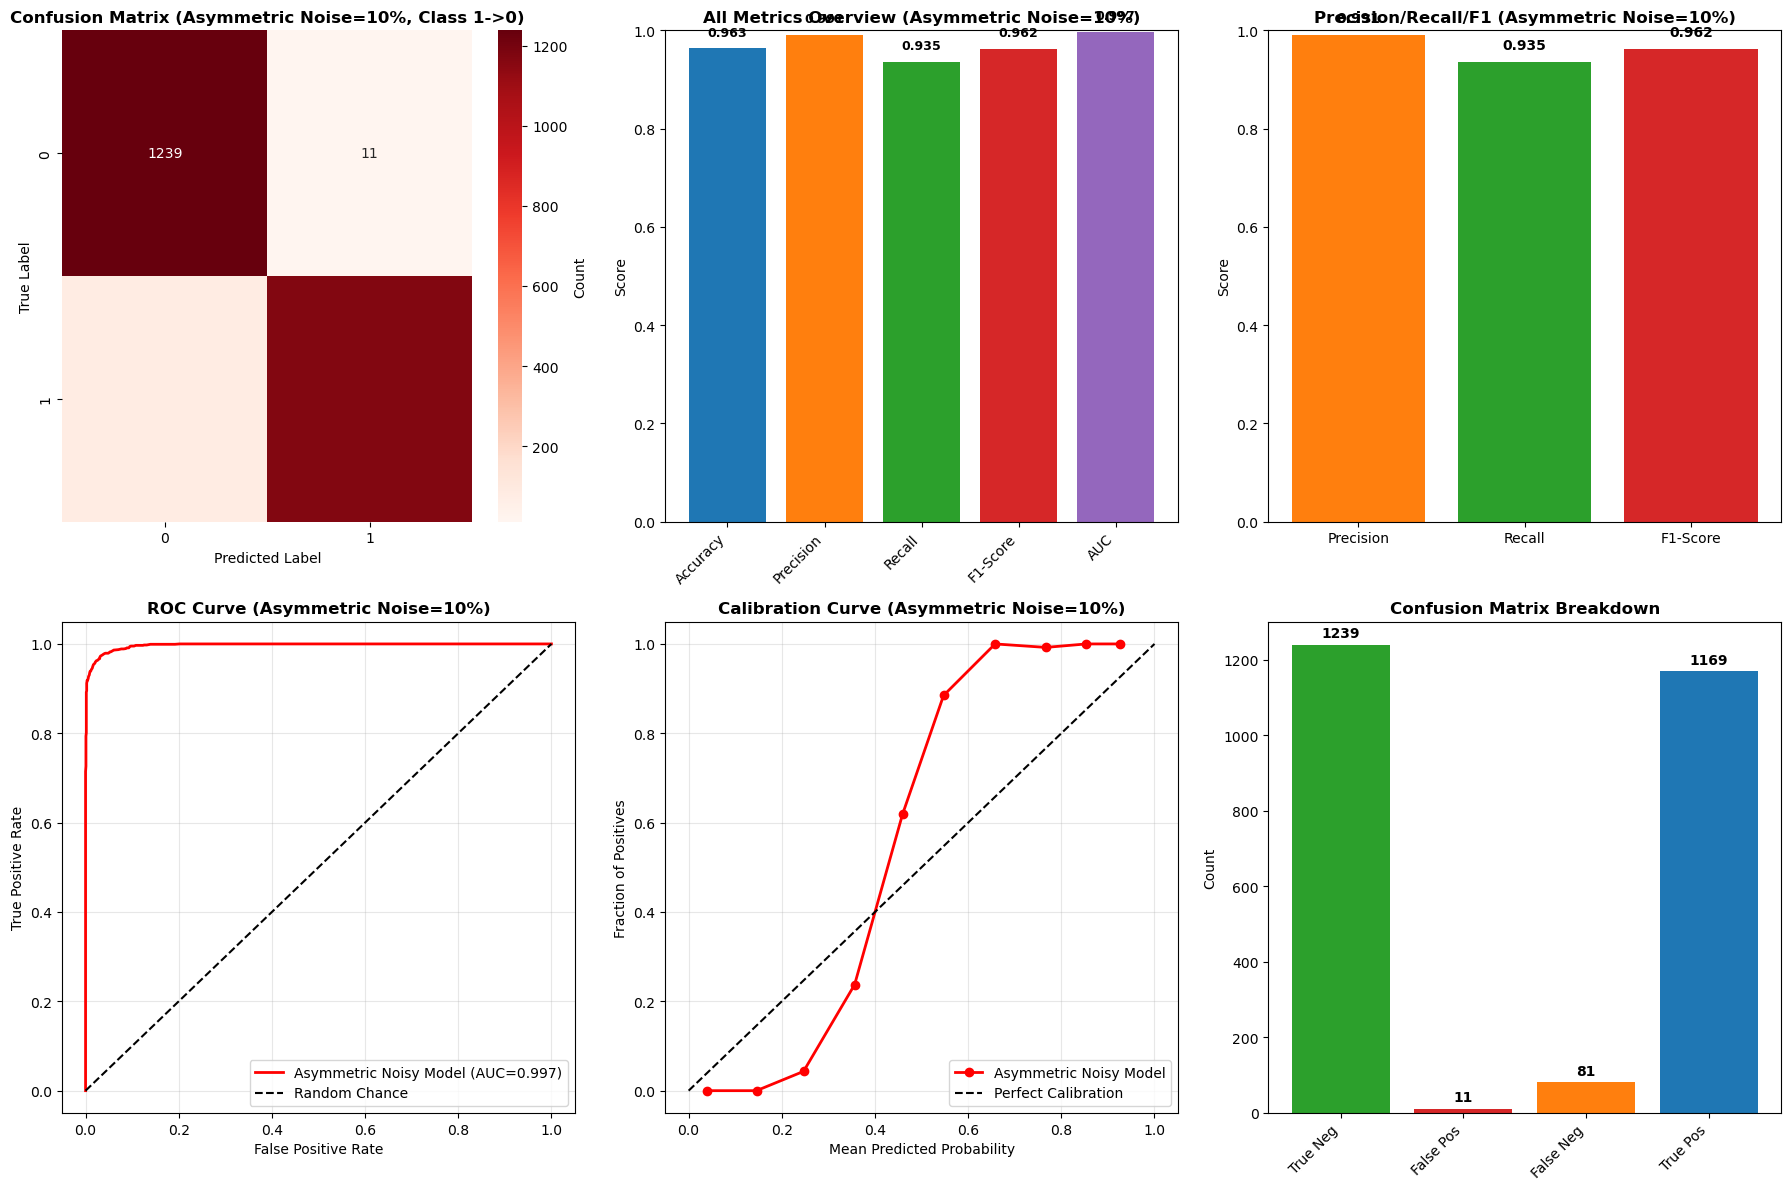


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.99      0.94      0.96      1320
     Default       0.94      0.99      0.96      1180

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.10


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 20%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4500 3000]
Flipped class 1 -> 0 at rate 0.2

RANDOM FOREST WITH 20% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.9484
Precision: 0.9956
Recall:    0.9008
F1 Score:  0.9458
AUC Score: 0.9963



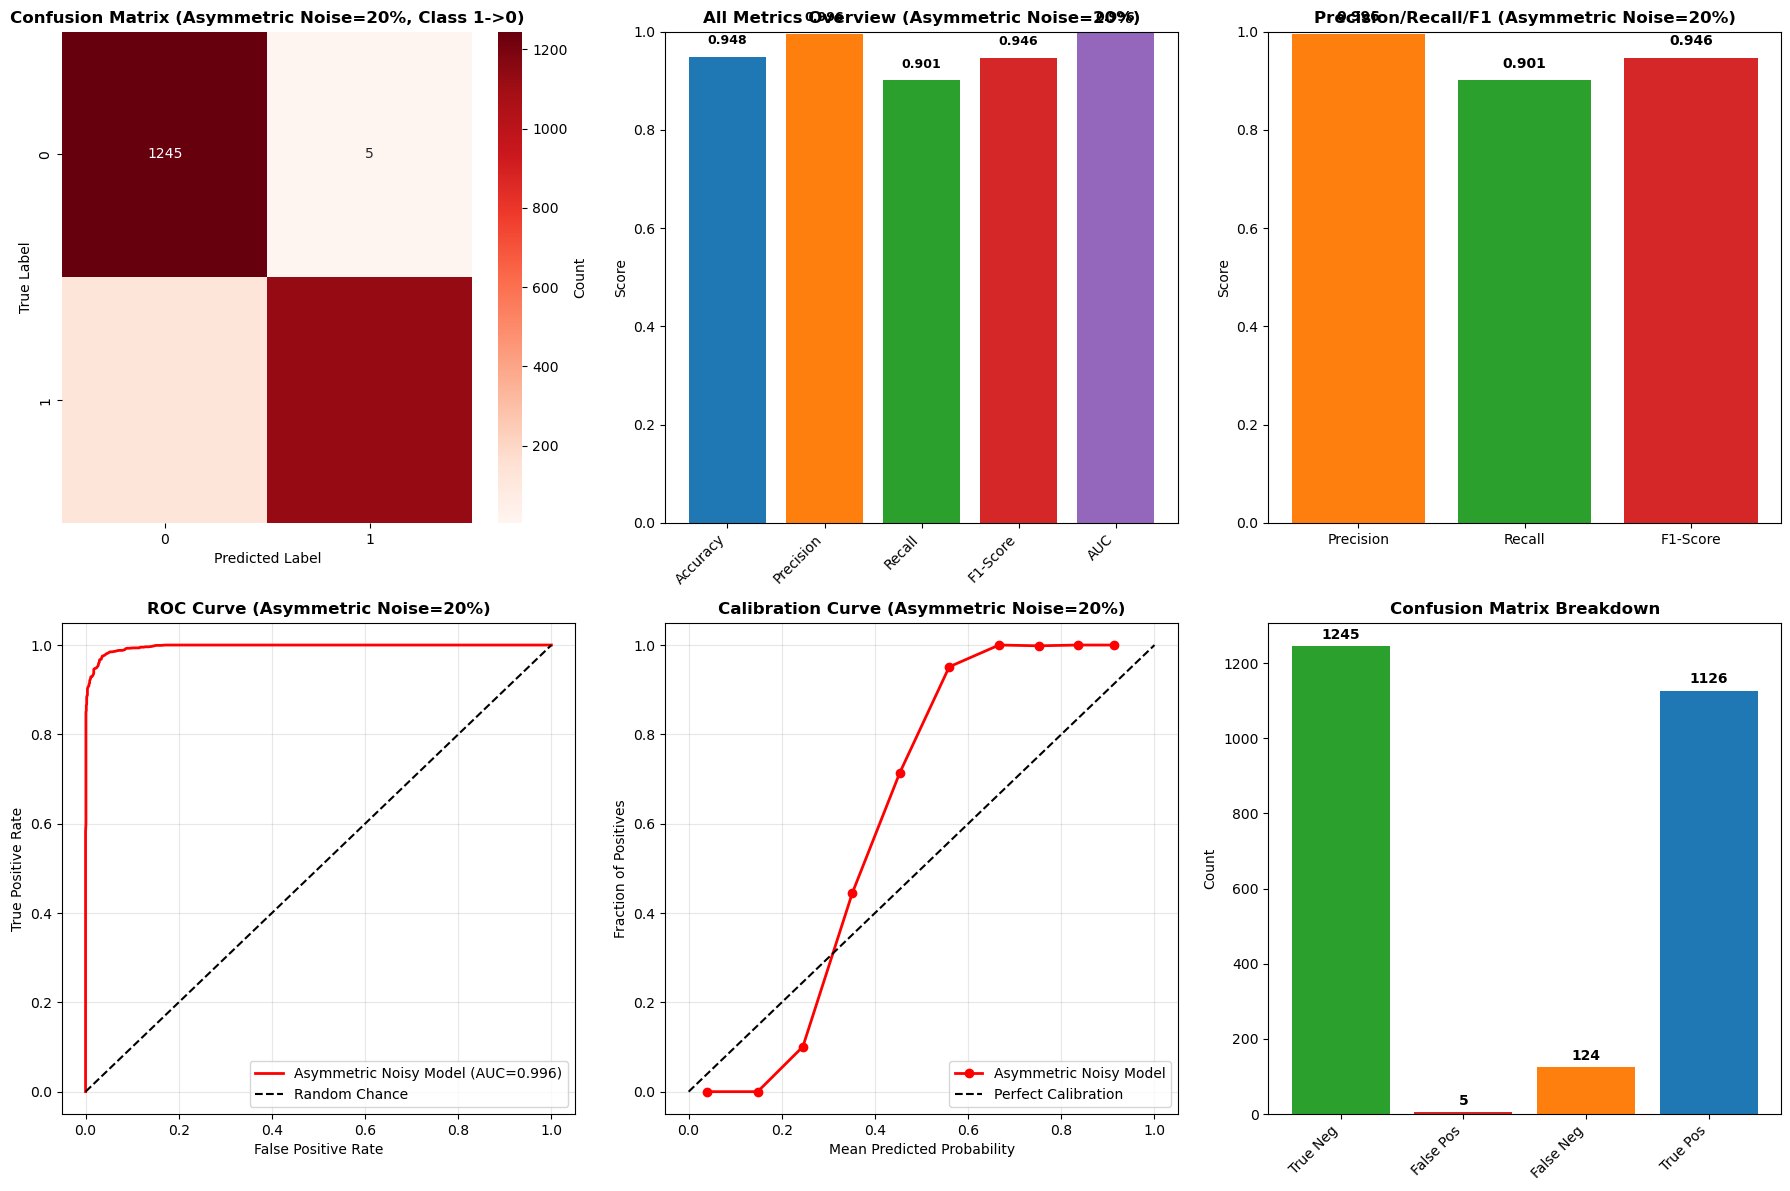


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       1.00      0.91      0.95      1369
     Default       0.90      1.00      0.95      1131

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.20


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 33%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4987 2513]
Flipped class 1 -> 0 at rate 0.33

RANDOM FOREST WITH 33% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.9156
Precision: 0.9981
Recall:    0.8328
F1 Score:  0.9080
AUC Score: 0.9959



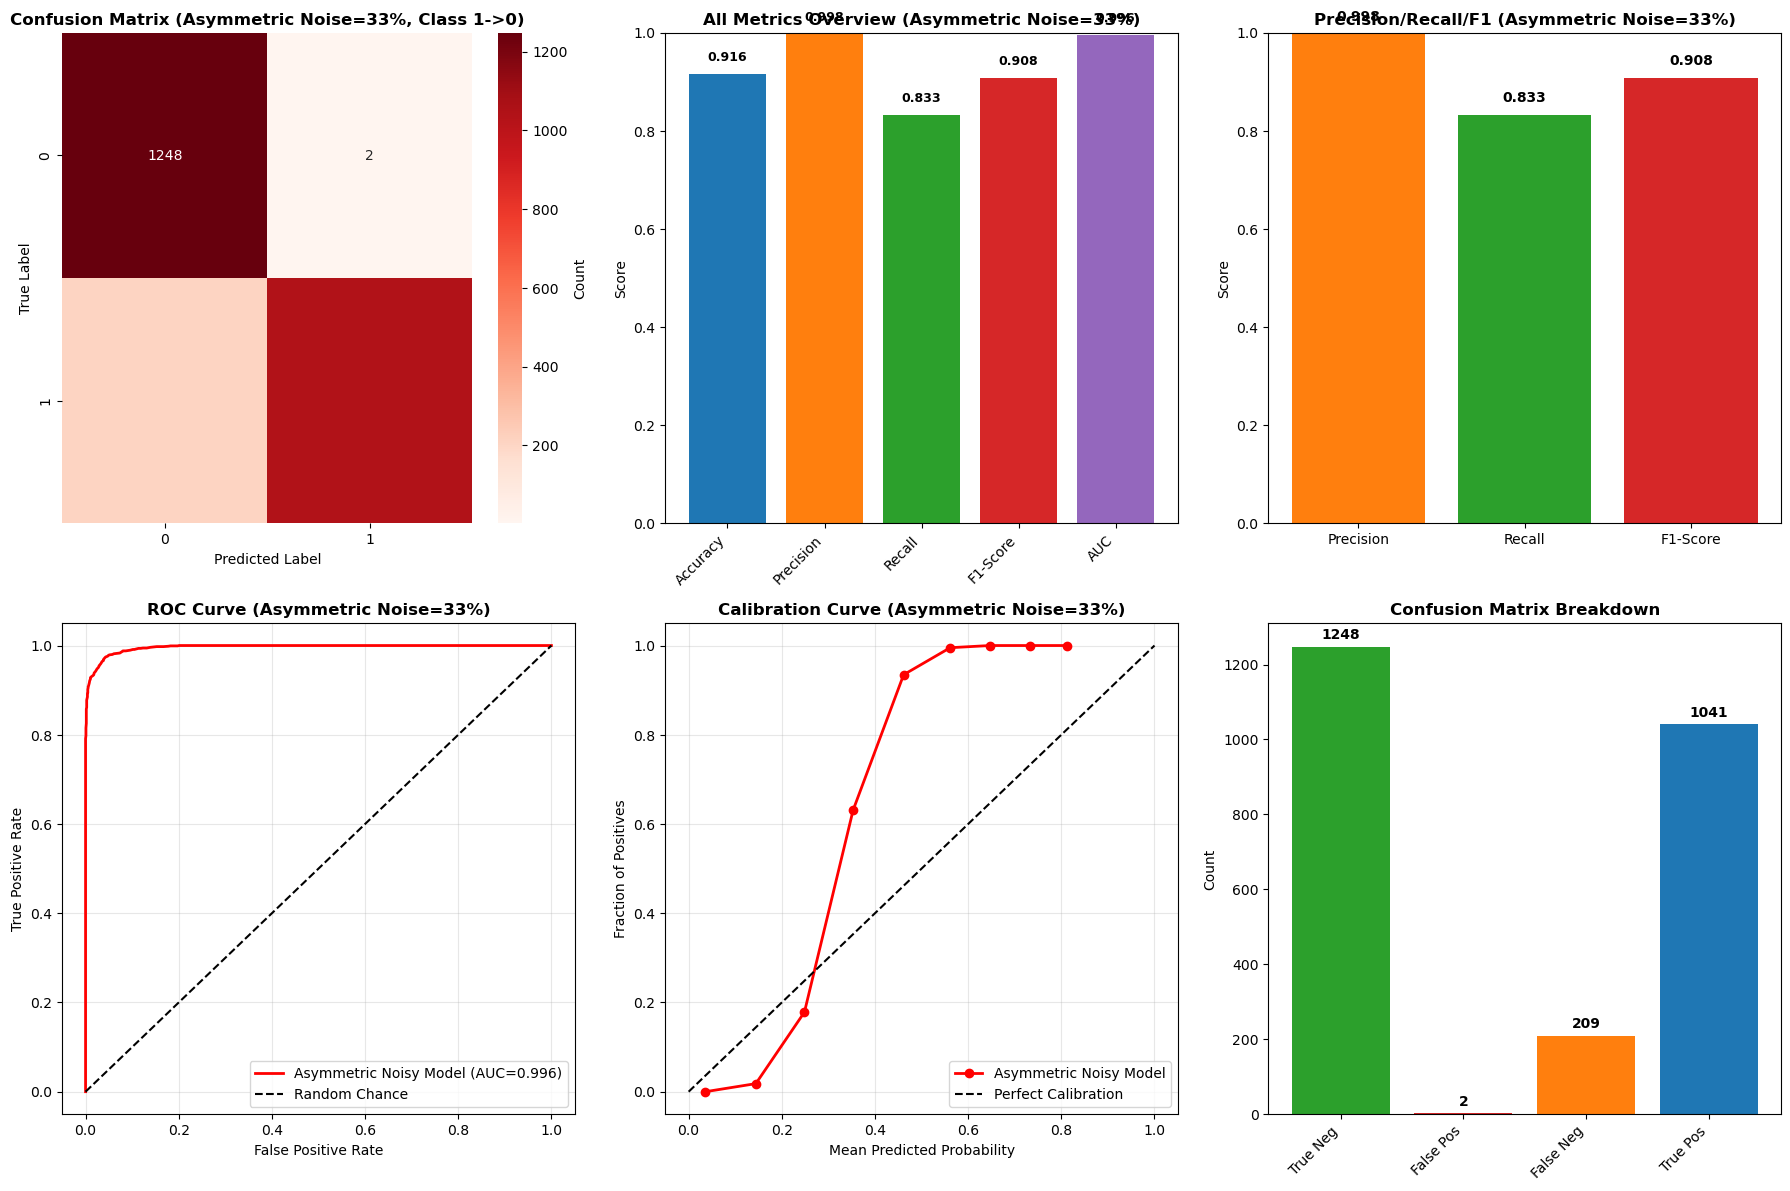


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       1.00      0.86      0.92      1457
     Default       0.83      1.00      0.91      1043

    accuracy                           0.92      2500
   macro avg       0.92      0.93      0.92      2500
weighted avg       0.93      0.92      0.92      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.33


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

## Noise 2 = Asymmetric Noise, 1 to 0, 50%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [5625 1875]
Flipped class 1 -> 0 at rate 0.5

RANDOM FOREST WITH 50% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.6376
Precision: 1.0000
Recall:    0.2752
F1 Score:  0.4316
AUC Score: 0.9933



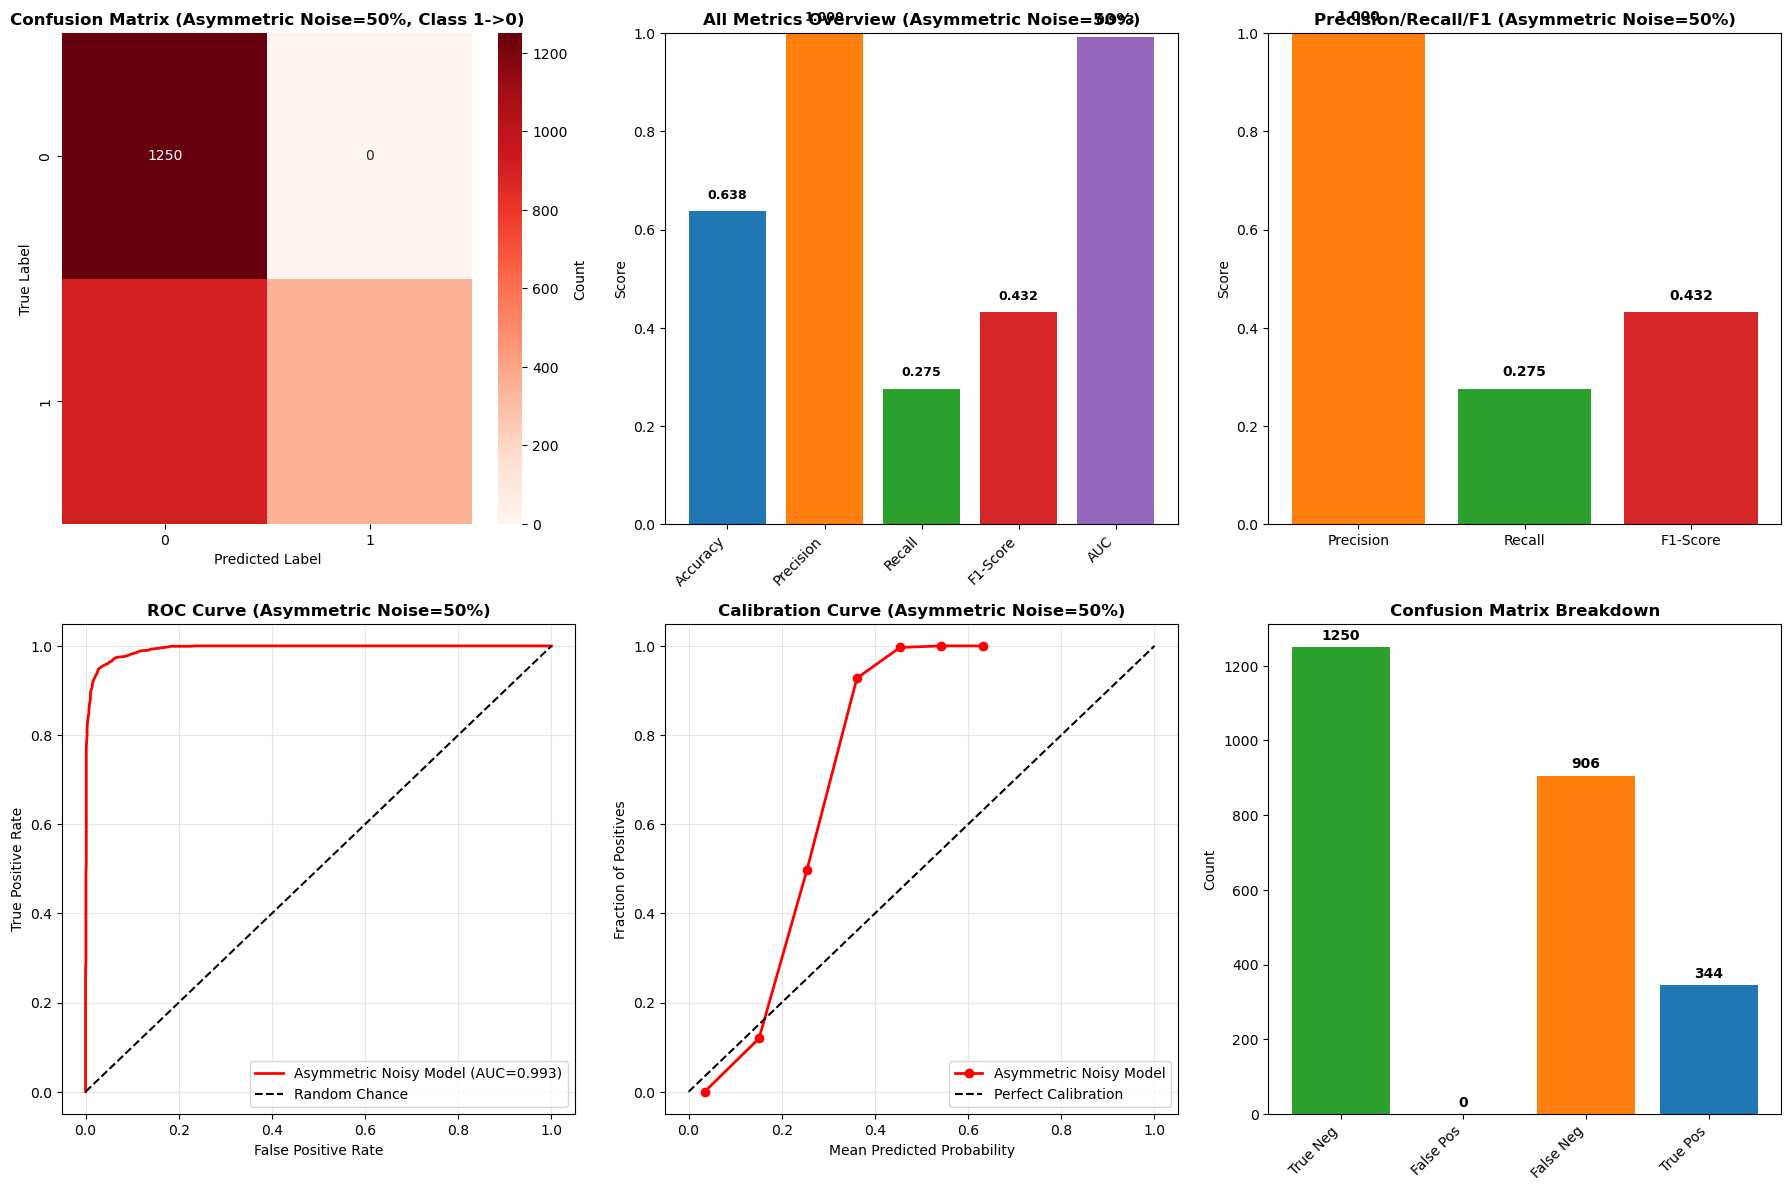


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       1.00      0.58      0.73      2156
     Default       0.28      1.00      0.43       344

    accuracy                           0.64      2500
   macro avg       0.64      0.79      0.58      2500
weighted avg       0.90      0.64      0.69      2500



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.50


y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)
print("Original label distribution:", np.bincount(y_train))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_pred_noisy, y_test, target_names=['No Default', 'Default']))

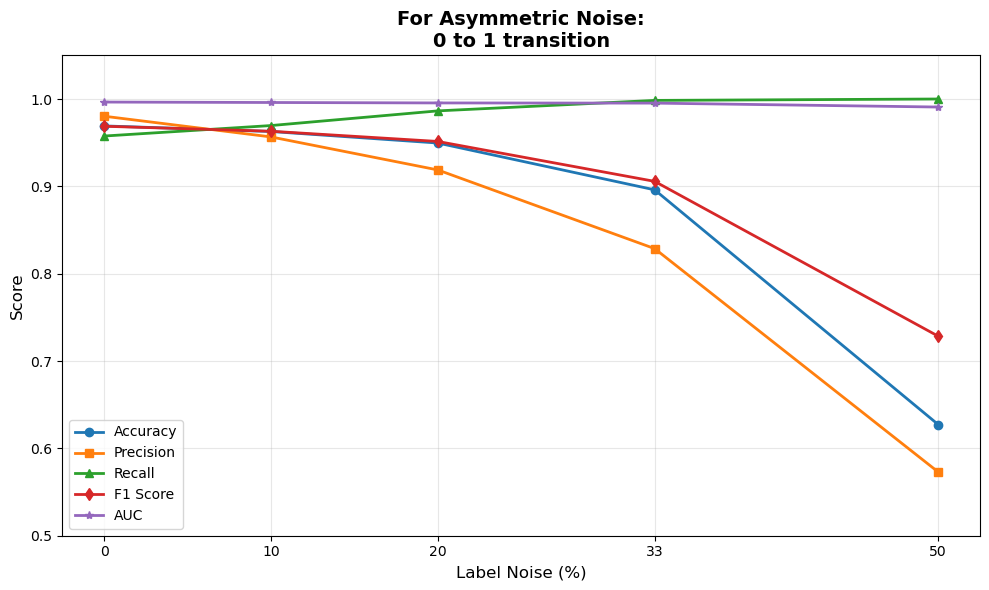

In [60]:
import matplotlib.pyplot as plt

label_noise = [0, 10, 20, 33, 50]
accuracy = [0.9692, 0.9628, 0.9496, 0.8960, 0.6272]
precision = [0.9803, 0.9566, 0.9188, 0.8287, 0.5729]
recall = [0.9576, 0.9696, 0.9864, 0.9984, 1.0000]
f1_score = [0.9688, 0.9631, 0.9514, 0.9057, 0.7284]
auc = [0.9965, 0.9960, 0.9955, 0.9953, 0.9908]

plt.figure(figsize=(10, 6))
plt.plot(label_noise, accuracy, marker='o', label='Accuracy', linewidth=2)
plt.plot(label_noise, precision, marker='s', label='Precision', linewidth=2)
plt.plot(label_noise, recall, marker='^', label='Recall', linewidth=2)
plt.plot(label_noise, f1_score, marker='d', label='F1 Score', linewidth=2)
plt.plot(label_noise, auc, marker='*', label='AUC', linewidth=2)

plt.xlabel('Label Noise (%)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('For Asymmetric Noise:\n0 to 1 transition', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(label_noise)
plt.ylim(0.5, 1.05)
plt.tight_layout()
plt.show()

## Noise 3 = Randomly pick 10% of labels and flip them.

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3770 3730]
Random flip rate: 0.1

RANDOM FOREST WITH 10% RANDOM LABEL FLIP
Accuracy:  0.9656
Precision: 0.9739
Recall:    0.9568
F1 Score:  0.9653
AUC Score: 0.9962



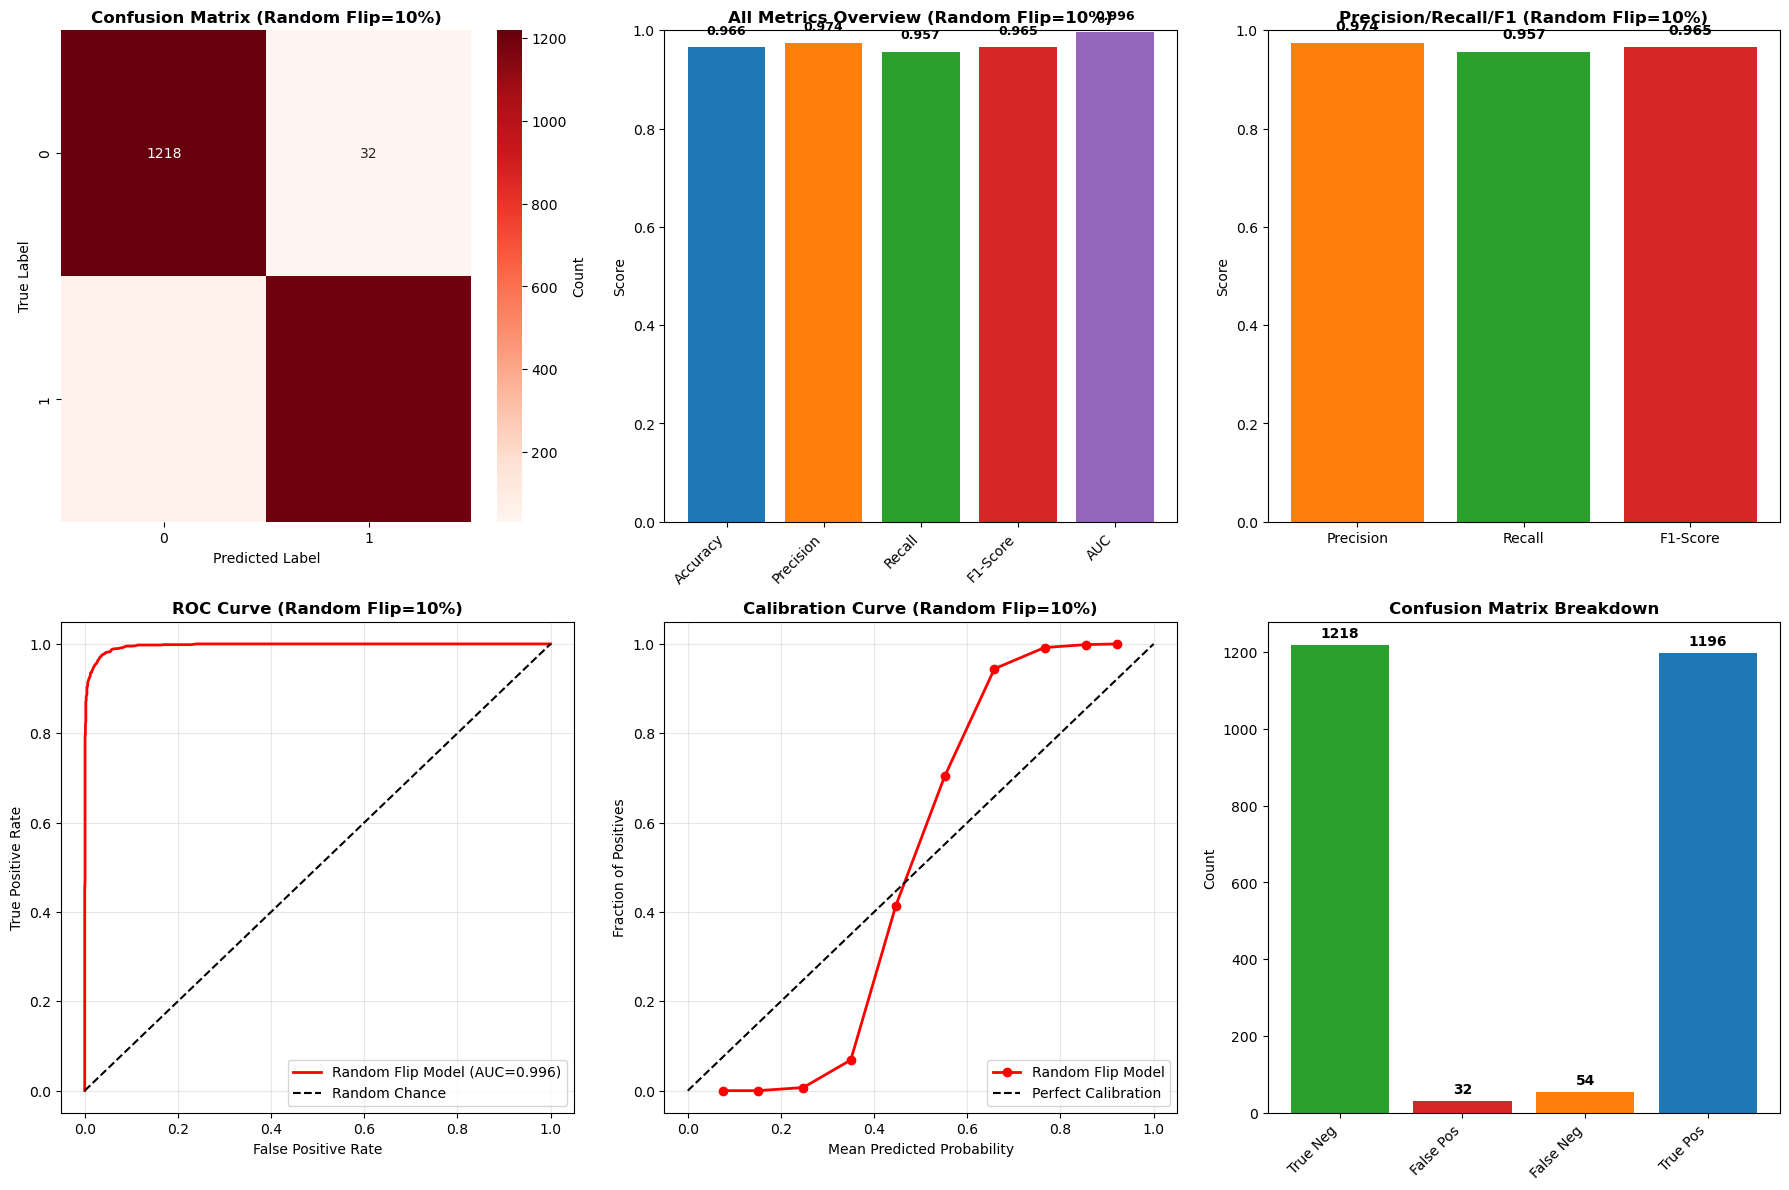


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.97      0.97      1250
     Default       0.97      0.96      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.10

y_train_noisy = inject_random_label_flip(y_train.values, flip_rate)
print("Original label distribution:", np.bincount(y_train))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 3 = Randomly pick 20% of labels and flip them.

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3752 3748]
Random flip rate: 0.2

RANDOM FOREST WITH 20% RANDOM LABEL FLIP
Accuracy:  0.9616
Precision: 0.9769
Recall:    0.9456
F1 Score:  0.9610
AUC Score: 0.9952



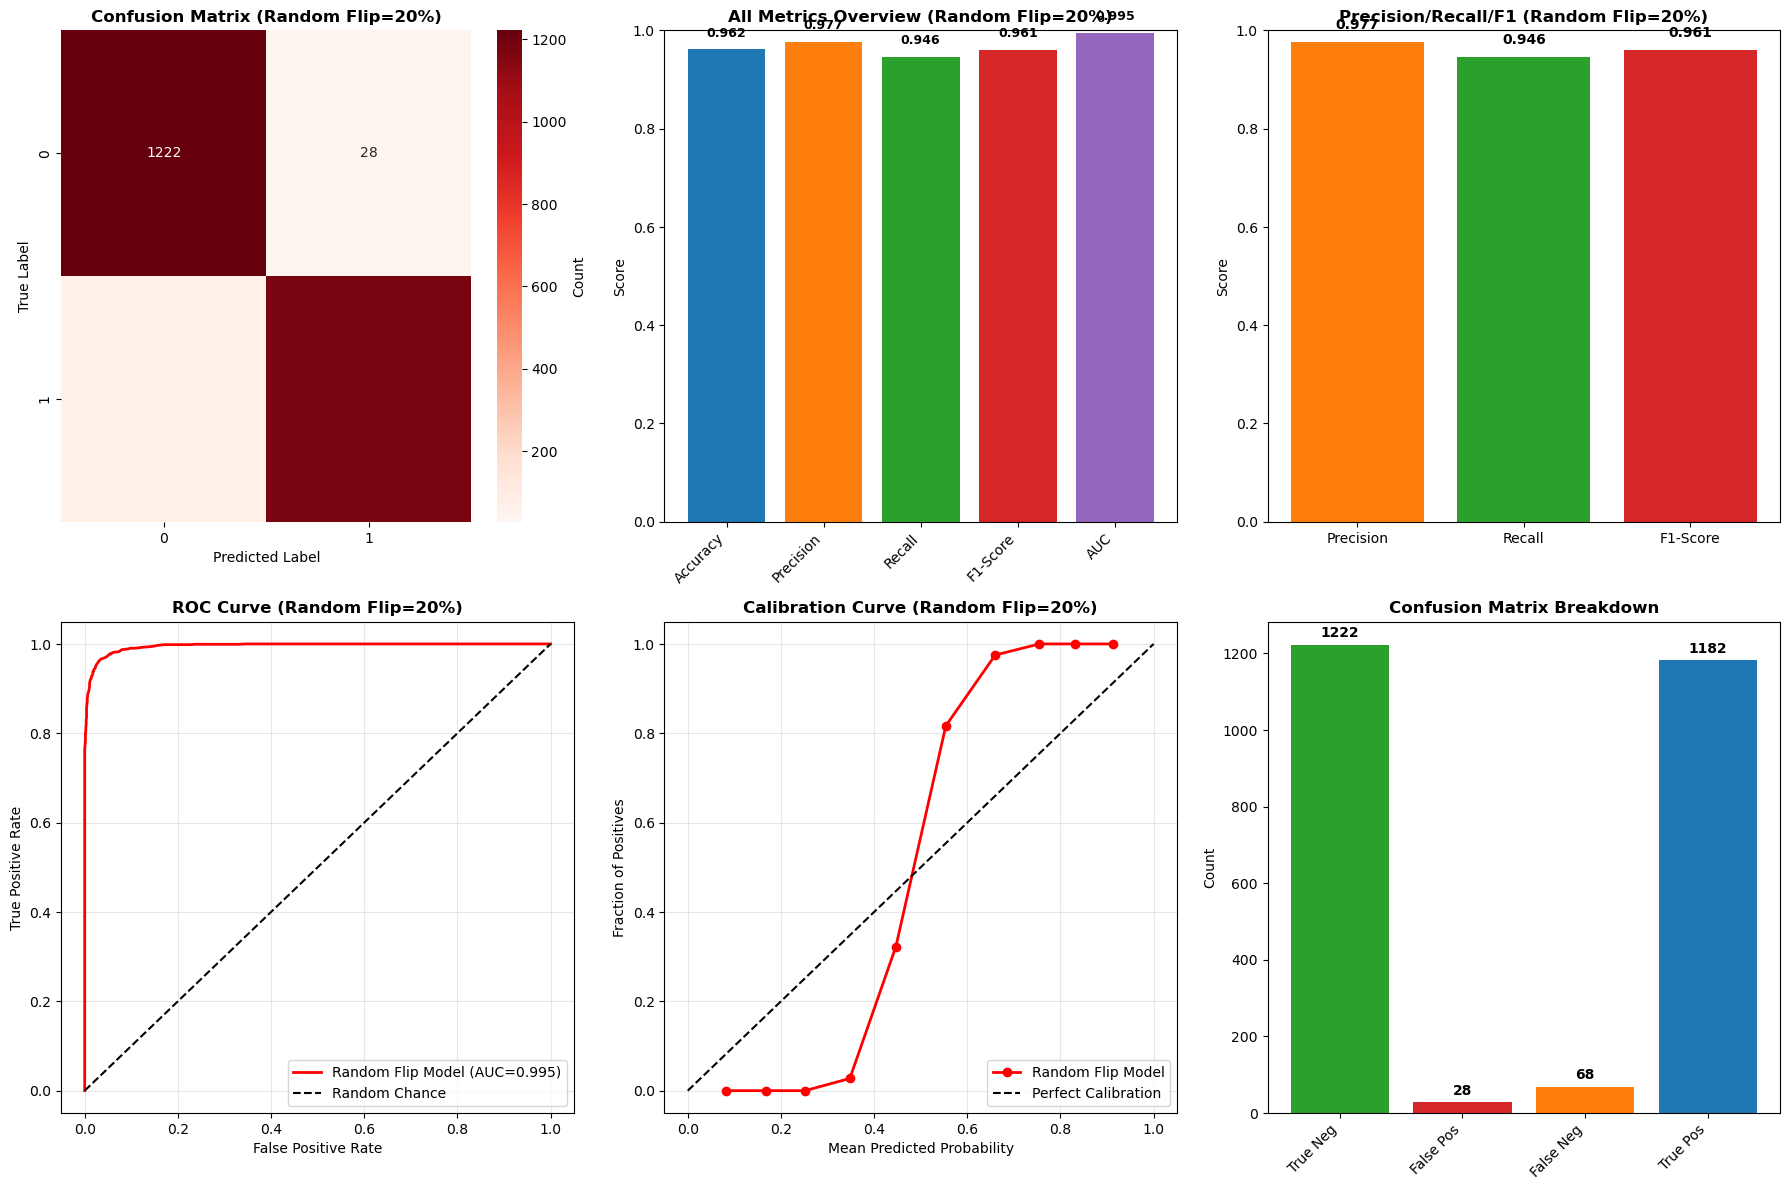


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.95      0.98      0.96      1250
     Default       0.98      0.95      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.20

y_train_noisy = inject_random_label_flip(y_train.values, flip_rate)
print("Original label distribution:", np.bincount(y_train))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 3 = Randomly pick 33% of labels and flip them.

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3743 3757]
Random flip rate: 0.33

RANDOM FOREST WITH 33% RANDOM LABEL FLIP
Accuracy:  0.9368
Precision: 0.9527
Recall:    0.9192
F1 Score:  0.9357
AUC Score: 0.9823



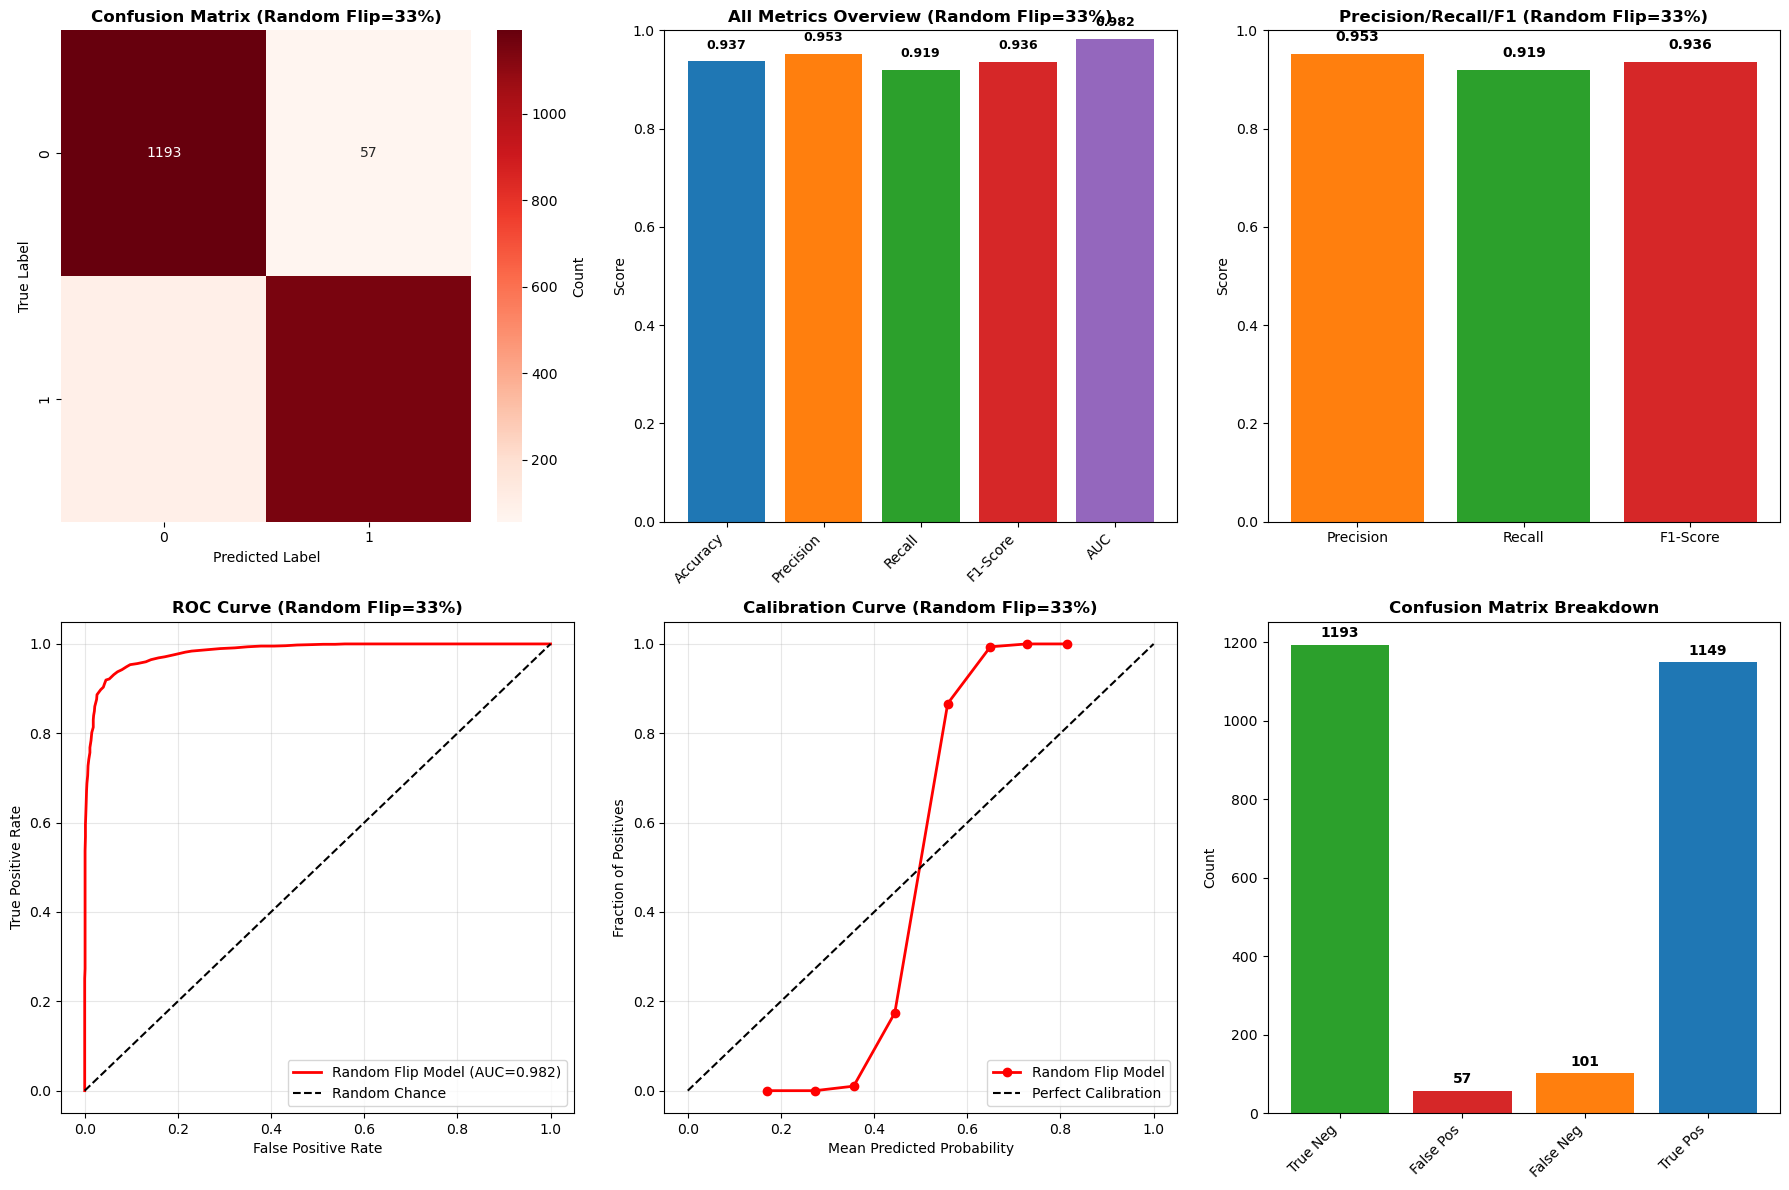


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.92      0.95      0.94      1250
     Default       0.95      0.92      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.33

y_train_noisy = inject_random_label_flip(y_train.values, flip_rate)
print("Original label distribution:", np.bincount(y_train))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 3 = Randomly pick 50% of labels and flip them.

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3826 3674]
Random flip rate: 0.5

RANDOM FOREST WITH 50% RANDOM LABEL FLIP
Accuracy:  0.5172
Precision: 0.5213
Recall:    0.4216
F1 Score:  0.4662
AUC Score: 0.5188



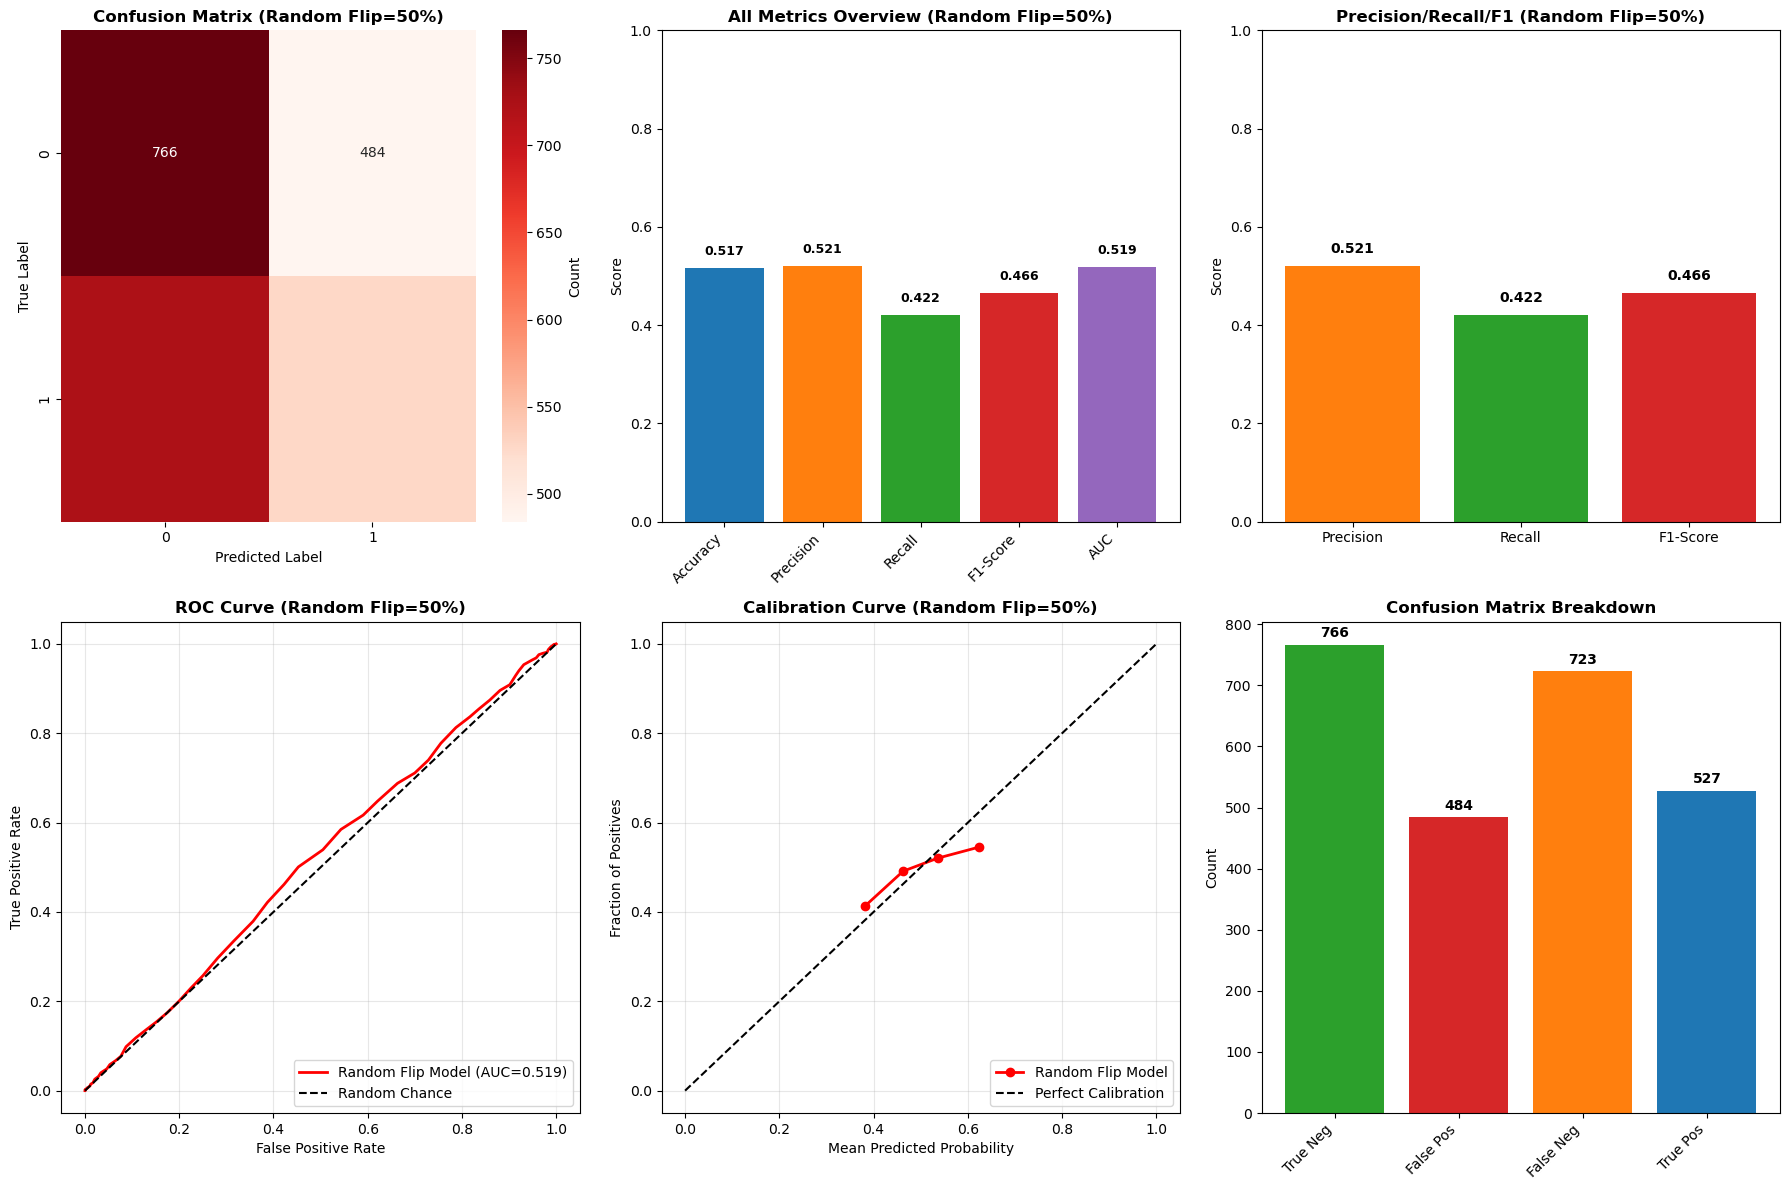


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.51      0.61      0.56      1250
     Default       0.52      0.42      0.47      1250

    accuracy                           0.52      2500
   macro avg       0.52      0.52      0.51      2500
weighted avg       0.52      0.52      0.51      2500



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.50

y_train_noisy = inject_random_label_flip(y_train.values, flip_rate)
print("Original label distribution:", np.bincount(y_train))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

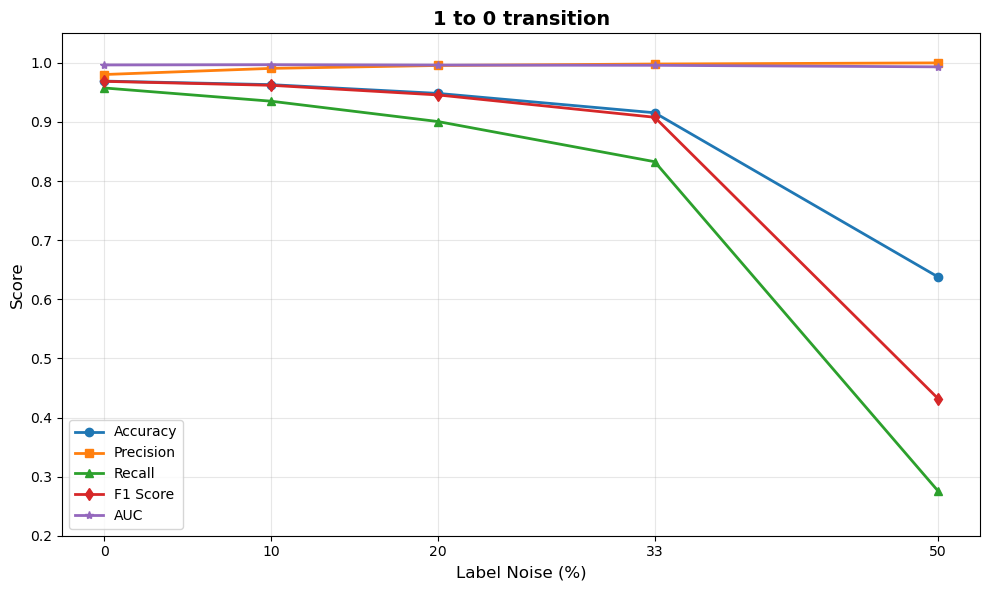

In [61]:
import matplotlib.pyplot as plt

label_noise = [0, 10, 20, 33, 50]
accuracy = [0.9692, 0.9632, 0.9484, 0.9156, 0.6376]
precision = [0.9803, 0.9907, 0.9956, 0.9981, 1.0000]
recall = [0.9576, 0.9352, 0.9008, 0.8328, 0.2752]
f1_score = [0.9688, 0.9621, 0.9458, 0.9080, 0.4316]
auc = [0.9965, 0.9969, 0.9963, 0.9959, 0.9933]

plt.figure(figsize=(10, 6))
plt.plot(label_noise, accuracy, marker='o', label='Accuracy', linewidth=2)
plt.plot(label_noise, precision, marker='s', label='Precision', linewidth=2)
plt.plot(label_noise, recall, marker='^', label='Recall', linewidth=2)
plt.plot(label_noise, f1_score, marker='d', label='F1 Score', linewidth=2)
plt.plot(label_noise, auc, marker='*', label='AUC', linewidth=2)

plt.xlabel('Label Noise (%)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('1 to 0 transition', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(label_noise)
plt.ylim(0.2, 1.05)
plt.tight_layout()
plt.show()

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(20%) and 1->0(5%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [3187 4313]
Noise rates: 0→1=0.2, 1→0=0.05

RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1=0.2, 1→0=0.05)
Accuracy:  0.9572
Precision: 0.9339
Recall:    0.9840
F1 Score:  0.9583
AUC Score: 0.9955



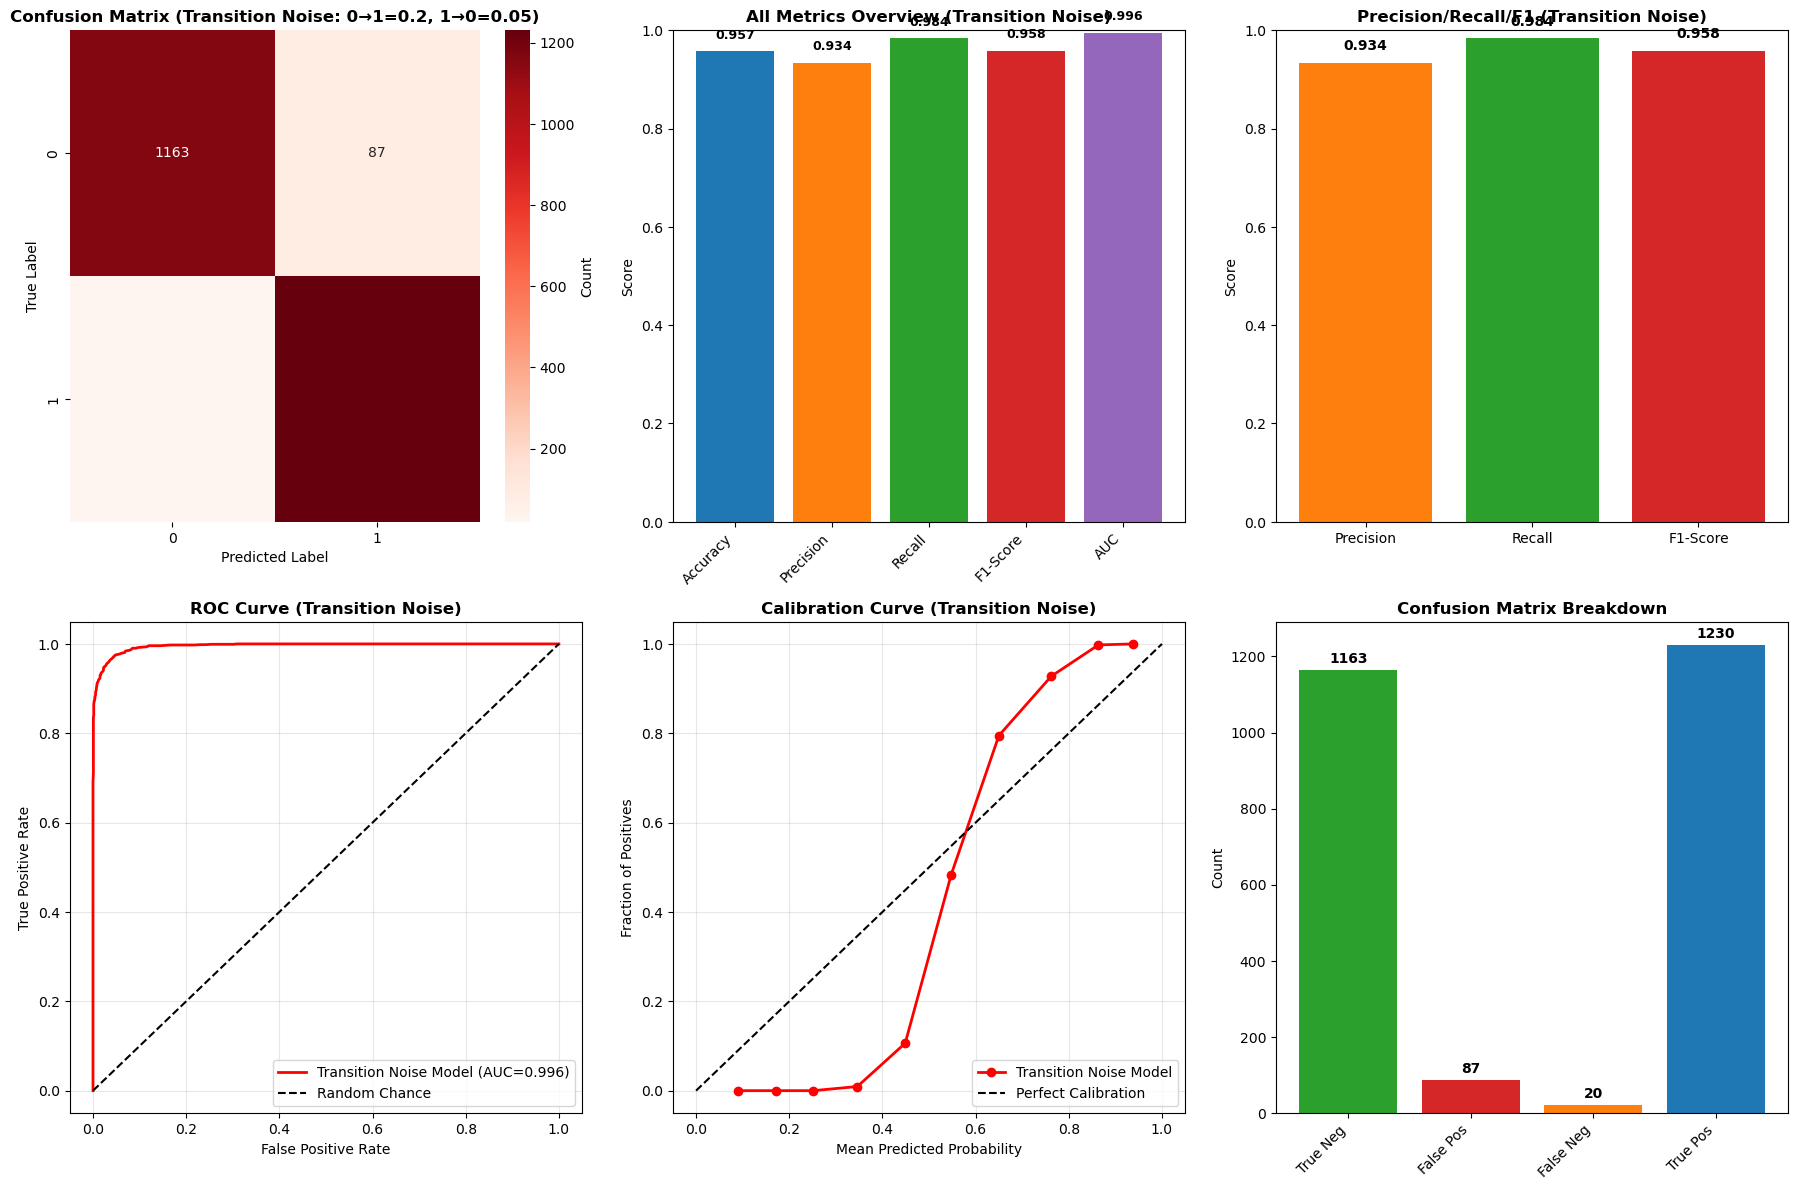


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.98      0.93      0.96      1250
     Default       0.93      0.98      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.20
eta_10 = 0.05

y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(5%) and 1->0(20%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [4313 3187]
Noise rates: 0→1=0.05, 1→0=0.2

RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1=0.05, 1→0=0.2)
Accuracy:  0.9536
Precision: 0.9880
Recall:    0.9184
F1 Score:  0.9519
AUC Score: 0.9956



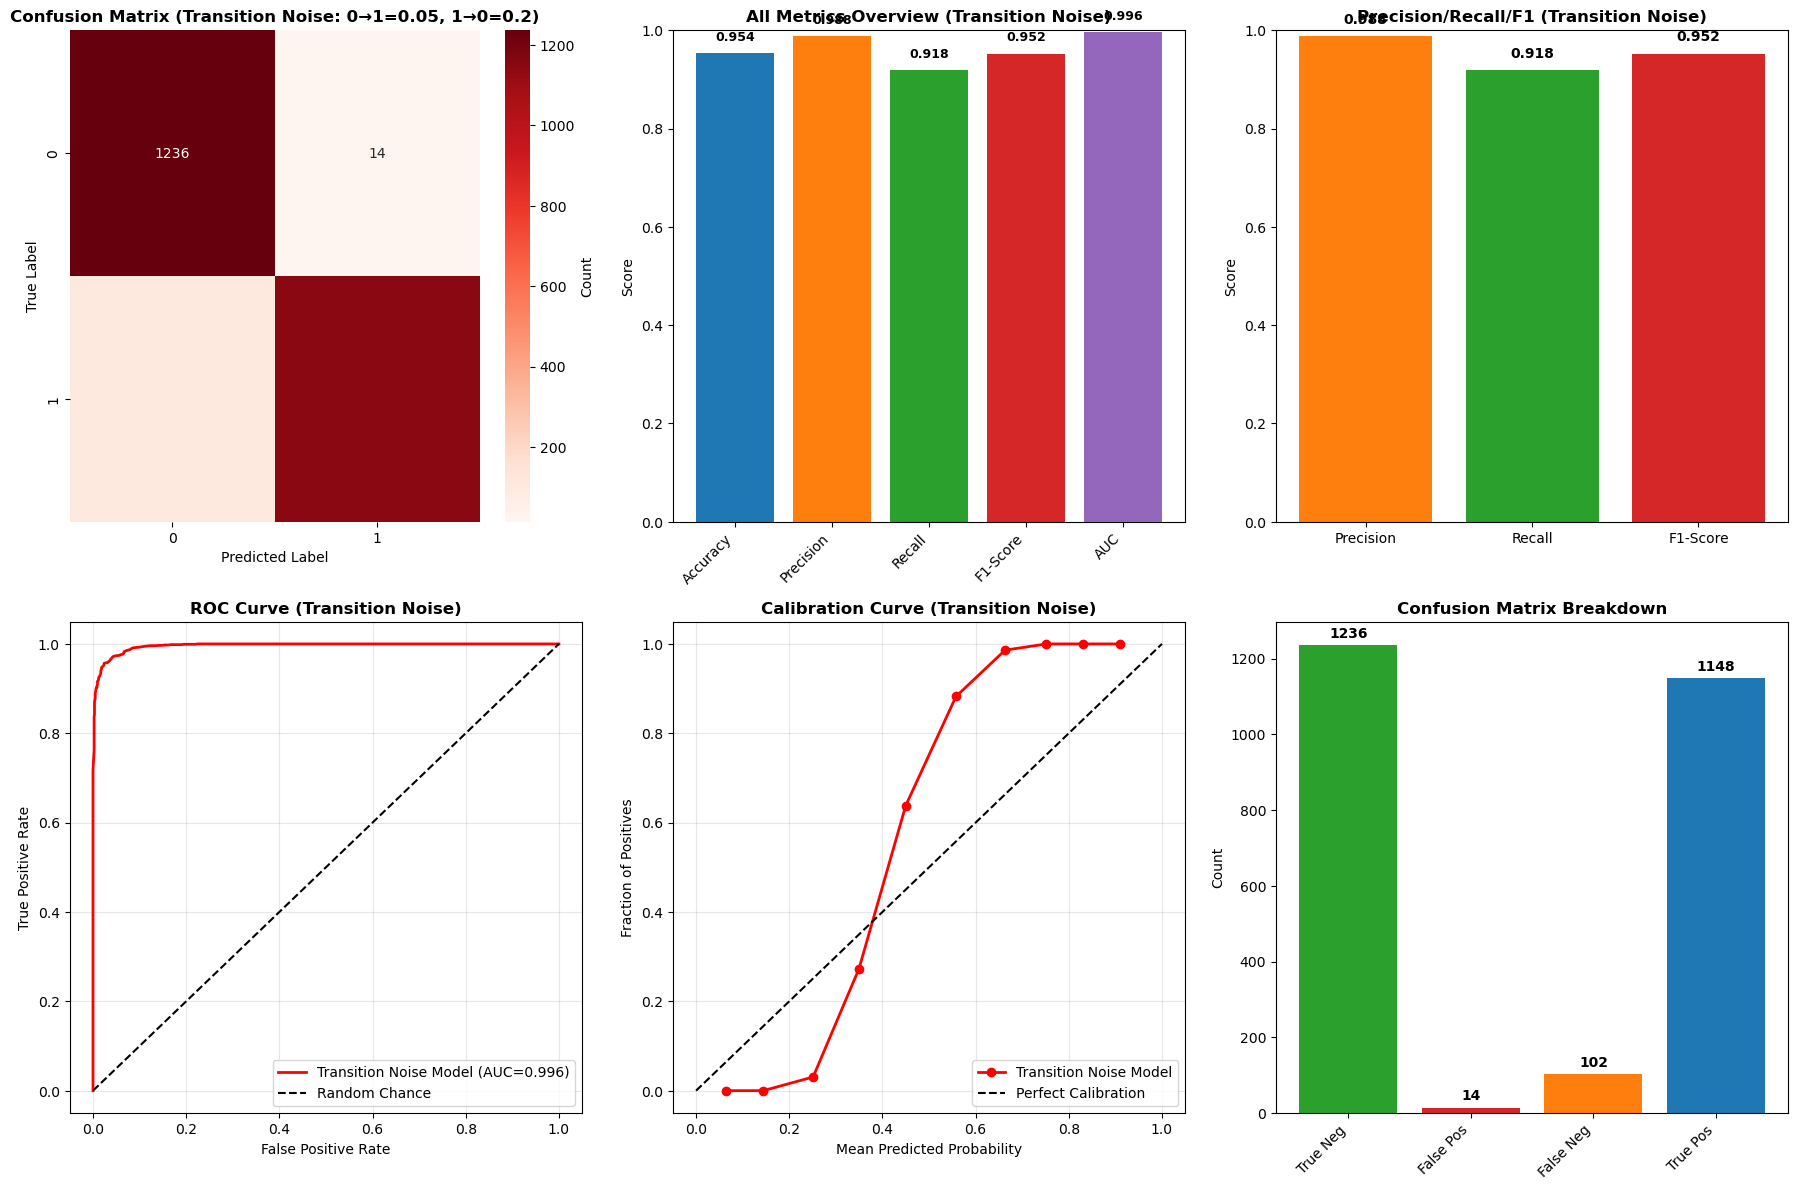


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.92      0.99      0.96      1250
     Default       0.99      0.92      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.96      0.95      0.95      2500
weighted avg       0.96      0.95      0.95      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.05
eta_10 = 0.20

y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(50%) and 1->0(10%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [2250 5250]
Noise rates: 0→1=0.5, 1→0=0.1

RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1=0.5, 1→0=0.1)
Accuracy:  0.6364
Precision: 0.5790
Recall:    1.0000
F1 Score:  0.7334
AUC Score: 0.9861



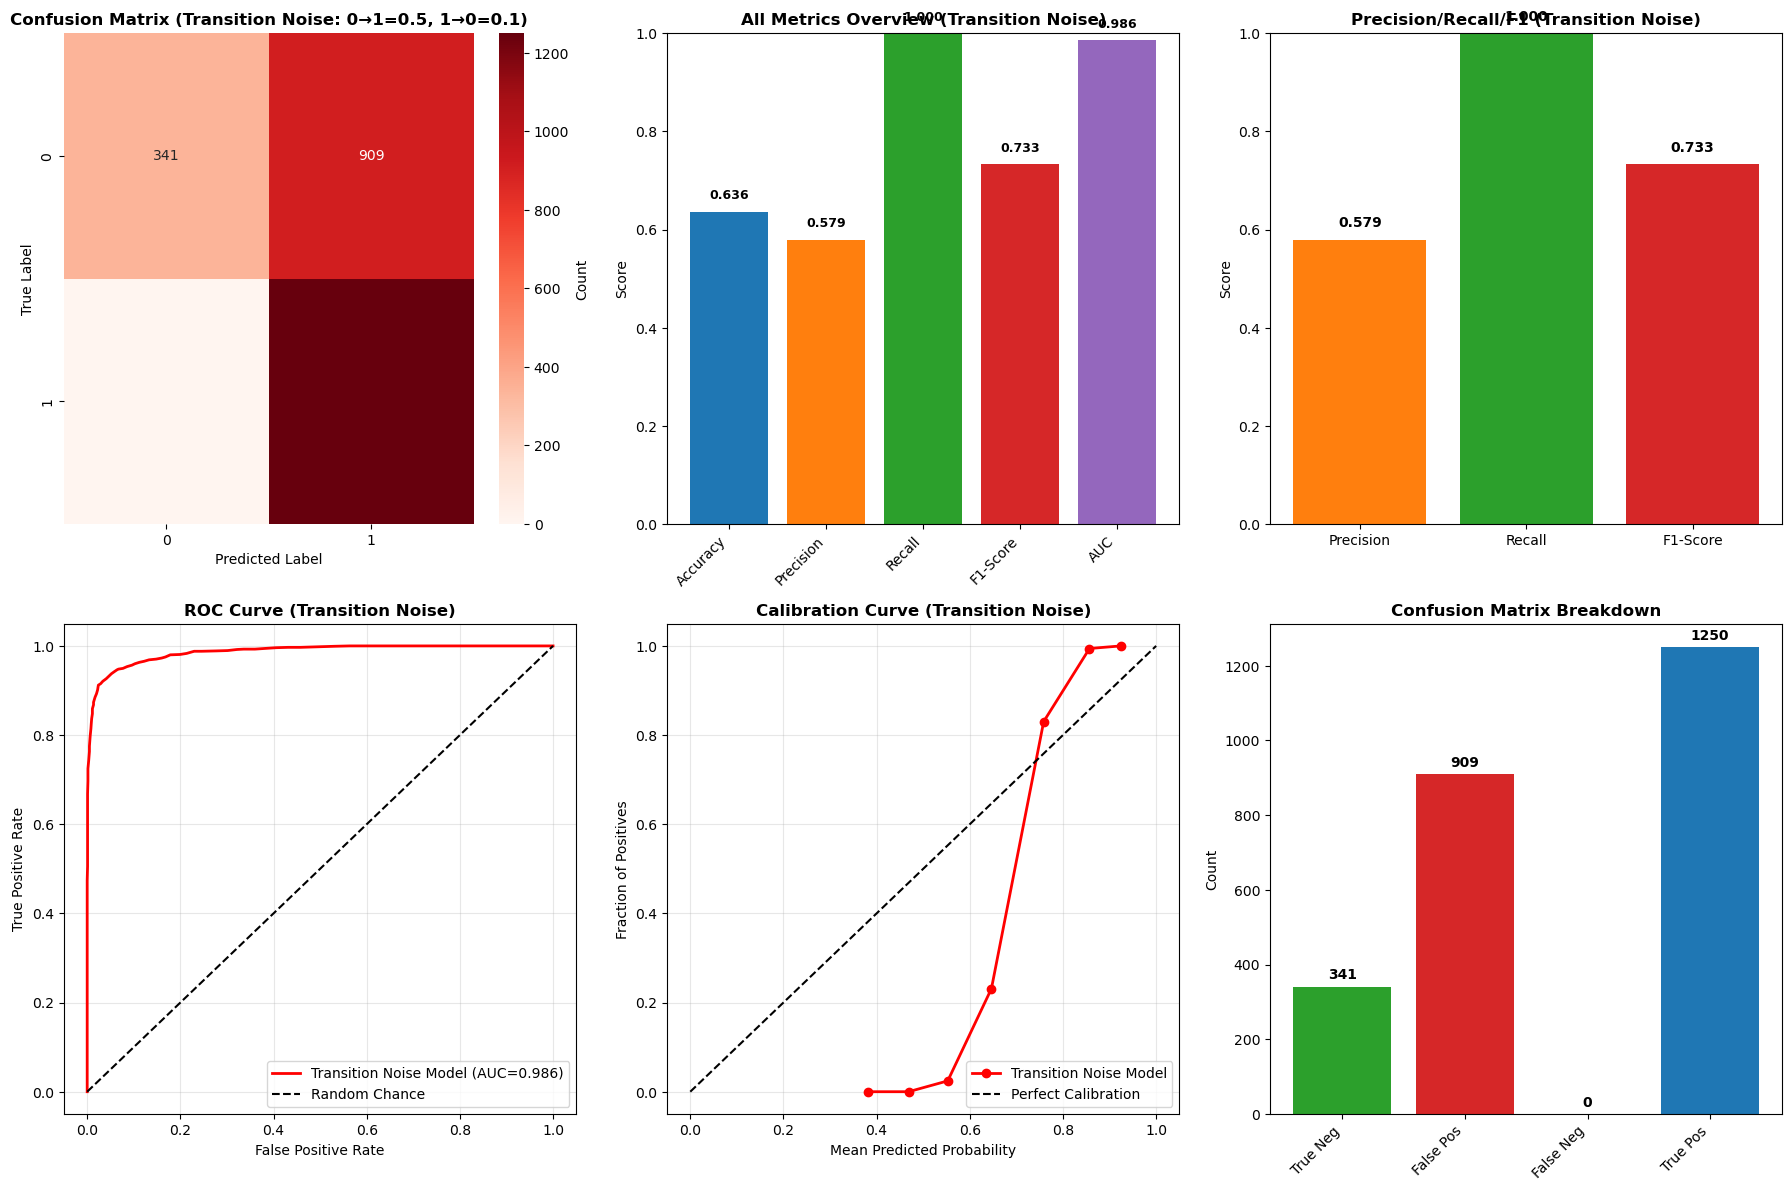


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       1.00      0.27      0.43      1250
     Default       0.58      1.00      0.73      1250

    accuracy                           0.64      2500
   macro avg       0.79      0.64      0.58      2500
weighted avg       0.79      0.64      0.58      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.50
eta_10 = 0.10

y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

## Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(10%) and 1->0(50%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [5250 2250]
Noise rates: 0→1=0.1, 1→0=0.5

RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1=0.1, 1→0=0.5)
Accuracy:  0.6400
Precision: 0.9972
Recall:    0.2808
F1 Score:  0.4382
AUC Score: 0.9837



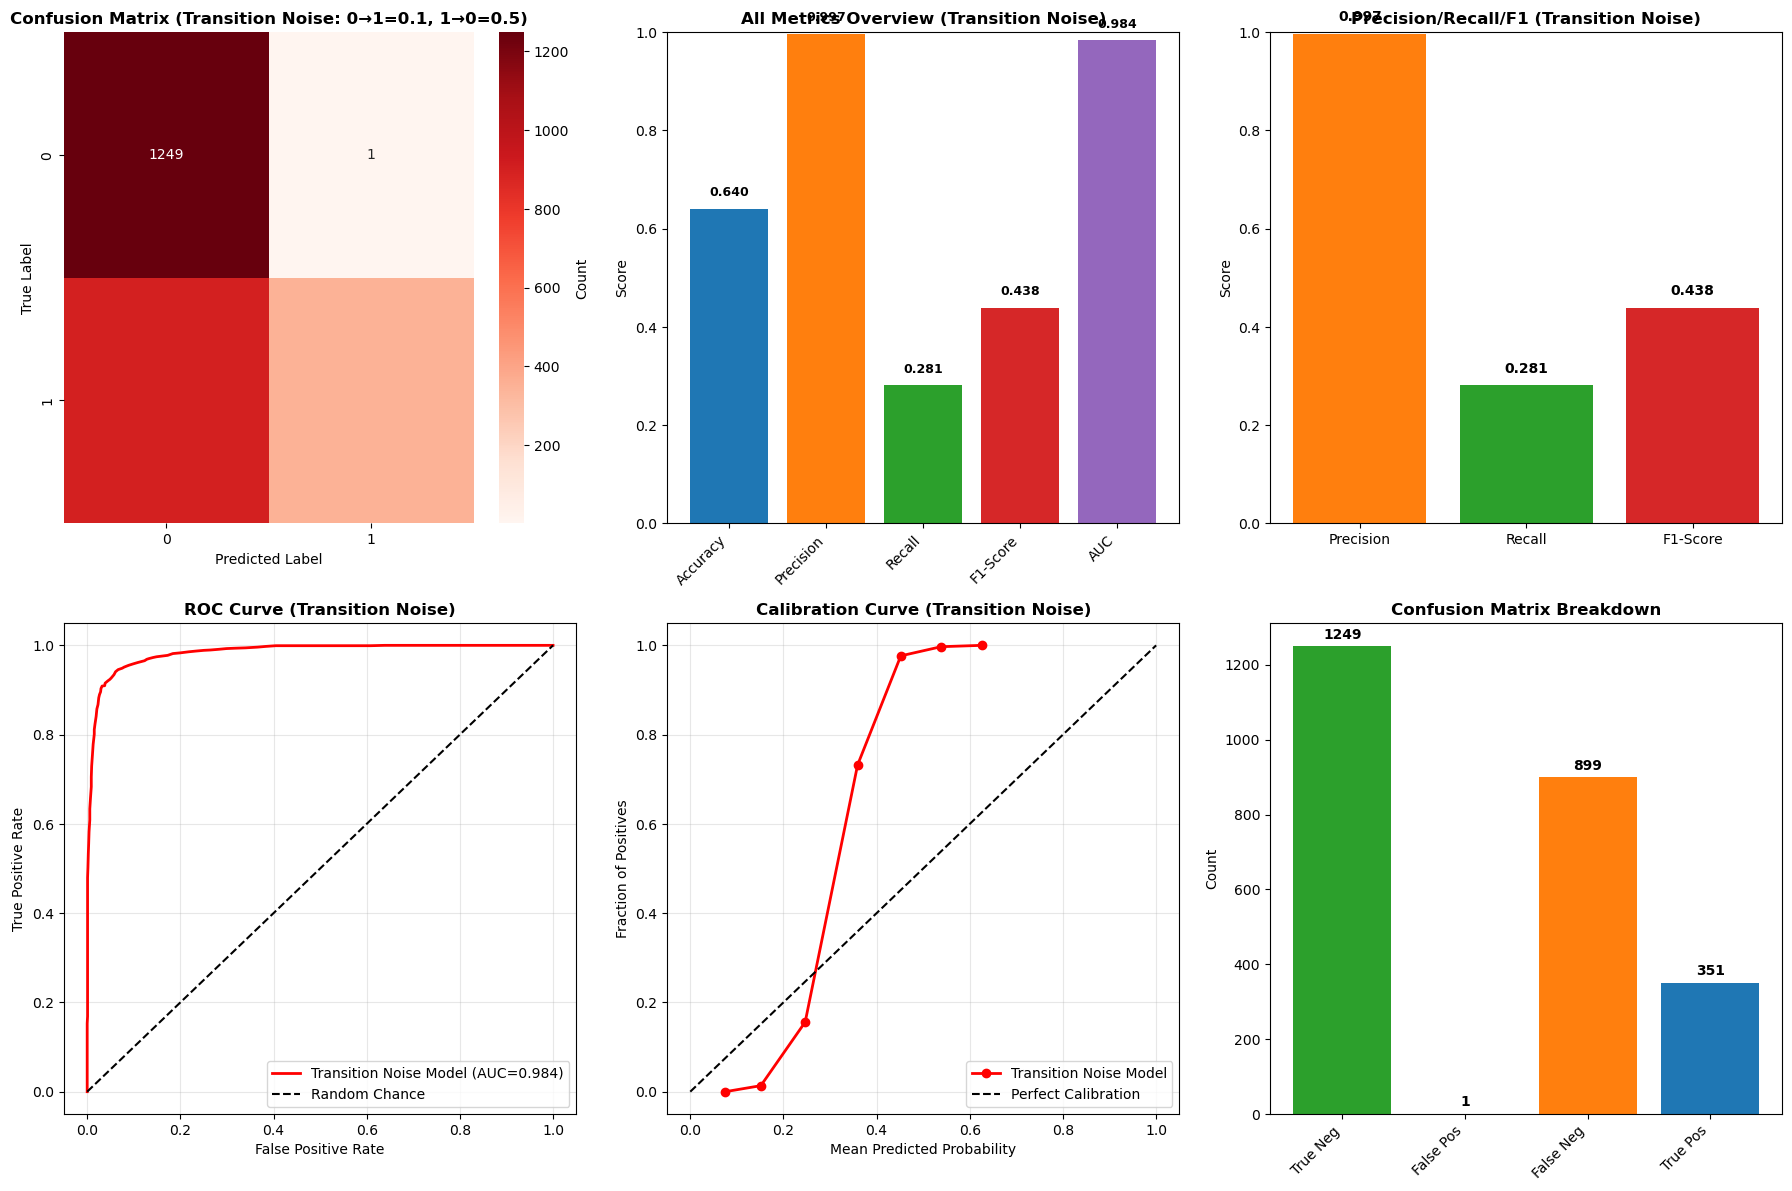


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.58      1.00      0.74      1250
     Default       1.00      0.28      0.44      1250

    accuracy                           0.64      2500
   macro avg       0.79      0.64      0.59      2500
weighted avg       0.79      0.64      0.59      2500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score, roc_curve, roc_auc_score, 
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.10
eta_10 = 0.50

y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)
print("Original label distribution:", np.bincount(y_train))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

rf_noisy = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = rf_noisy.predict(X_test)
y_prob_noisy = rf_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results" not in results:
    results["noise_results"] = {}
results["noise_results"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"RANDOM FOREST WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

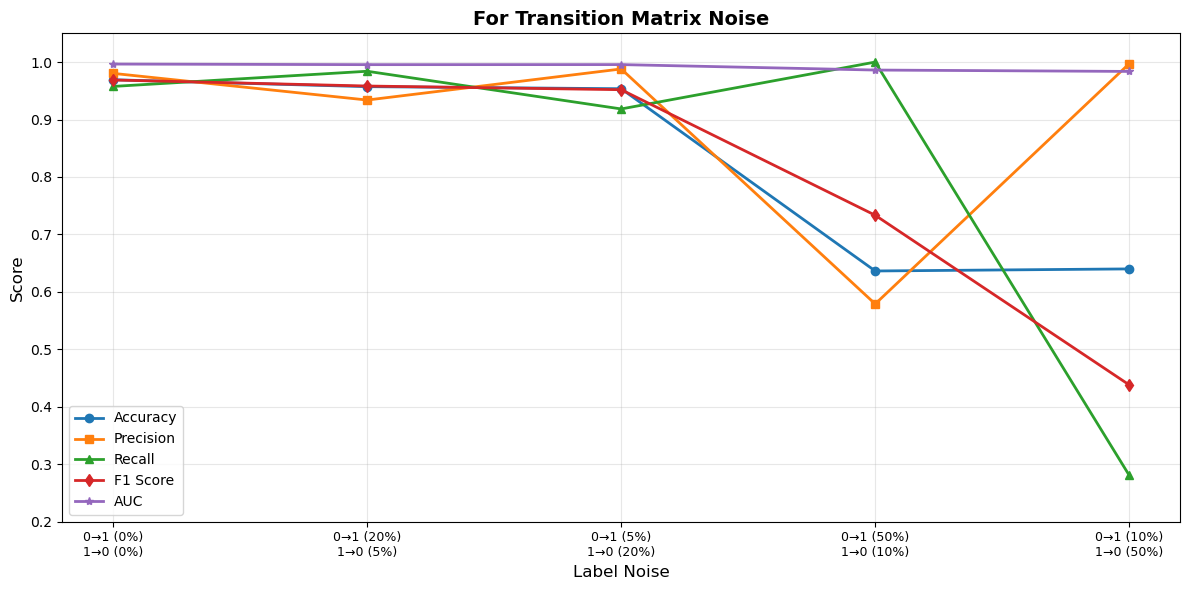

In [63]:
import matplotlib.pyplot as plt

labels = ['0→1 (0%)\n1→0 (0%)', '0→1 (20%)\n1→0 (5%)', '0→1 (5%)\n1→0 (20%)', 
          '0→1 (50%)\n1→0 (10%)', '0→1 (10%)\n1→0 (50%)']
accuracy = [0.9692, 0.9572, 0.9536, 0.6364, 0.6400]
precision = [0.9803, 0.9339, 0.9880, 0.5790, 0.9972]
recall = [0.9576, 0.9840, 0.9184, 1.000, 0.2808]
f1_score = [0.9688, 0.9583, 0.9519, 0.7334, 0.4382]
auc = [0.9965, 0.9955, 0.9956, 0.9861, 0.9837]

x = range(len(labels))

plt.figure(figsize=(12, 6))
plt.plot(x, accuracy, marker='o', label='Accuracy', linewidth=2)
plt.plot(x, precision, marker='s', label='Precision', linewidth=2)
plt.plot(x, recall, marker='^', label='Recall', linewidth=2)
plt.plot(x, f1_score, marker='d', label='F1 Score', linewidth=2)
plt.plot(x, auc, marker='*', label='AUC', linewidth=2)

plt.xlabel('Label Noise', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('For Transition Matrix Noise', fontsize=14, fontweight='bold')
plt.xticks(x, labels, fontsize=9)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(0.2, 1.05)
plt.tight_layout()
plt.show()

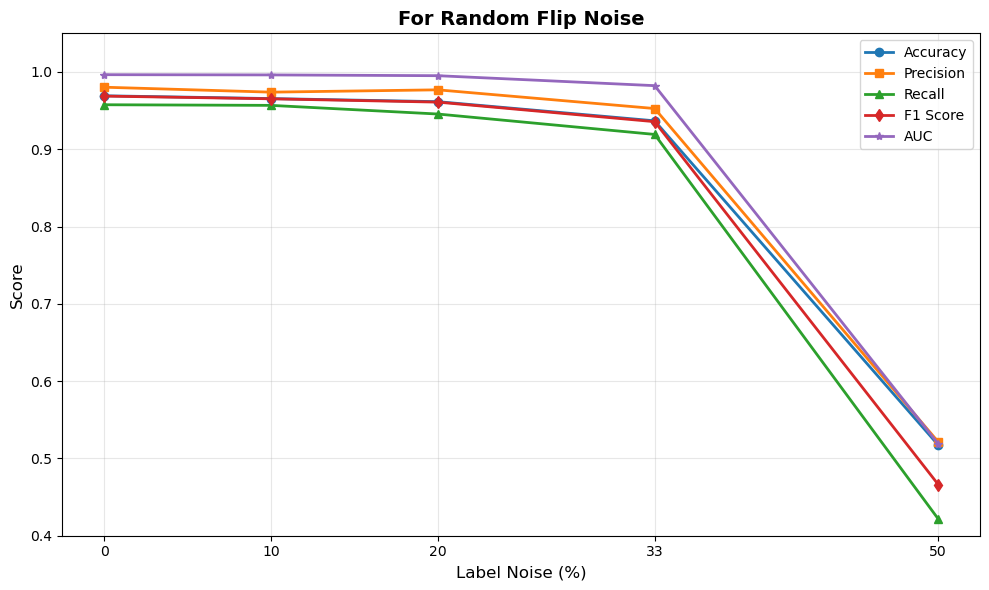

In [64]:
import matplotlib.pyplot as plt

label_noise = [0, 10, 20, 33, 50]
accuracy = [0.9692, 0.9656, 0.9616, 0.9368, 0.5172]
precision = [0.9803, 0.9739, 0.9769, 0.9527, 0.5213]
recall = [0.9576, 0.9568, 0.9456, 0.9192, 0.4216]
f1_score = [0.9688, 0.9653, 0.9610, 0.9357, 0.4662]
auc = [0.9965, 0.9962, 0.9952, 0.9823, 0.5188]

plt.figure(figsize=(10, 6))
plt.plot(label_noise, accuracy, marker='o', label='Accuracy', linewidth=2)
plt.plot(label_noise, precision, marker='s', label='Precision', linewidth=2)
plt.plot(label_noise, recall, marker='^', label='Recall', linewidth=2)
plt.plot(label_noise, f1_score, marker='d', label='F1 Score', linewidth=2)
plt.plot(label_noise, auc, marker='*', label='AUC', linewidth=2)

plt.xlabel('Label Noise (%)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('For Random Flip Noise', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(label_noise)
plt.ylim(0.4, 1.05)
plt.tight_layout()
plt.show()

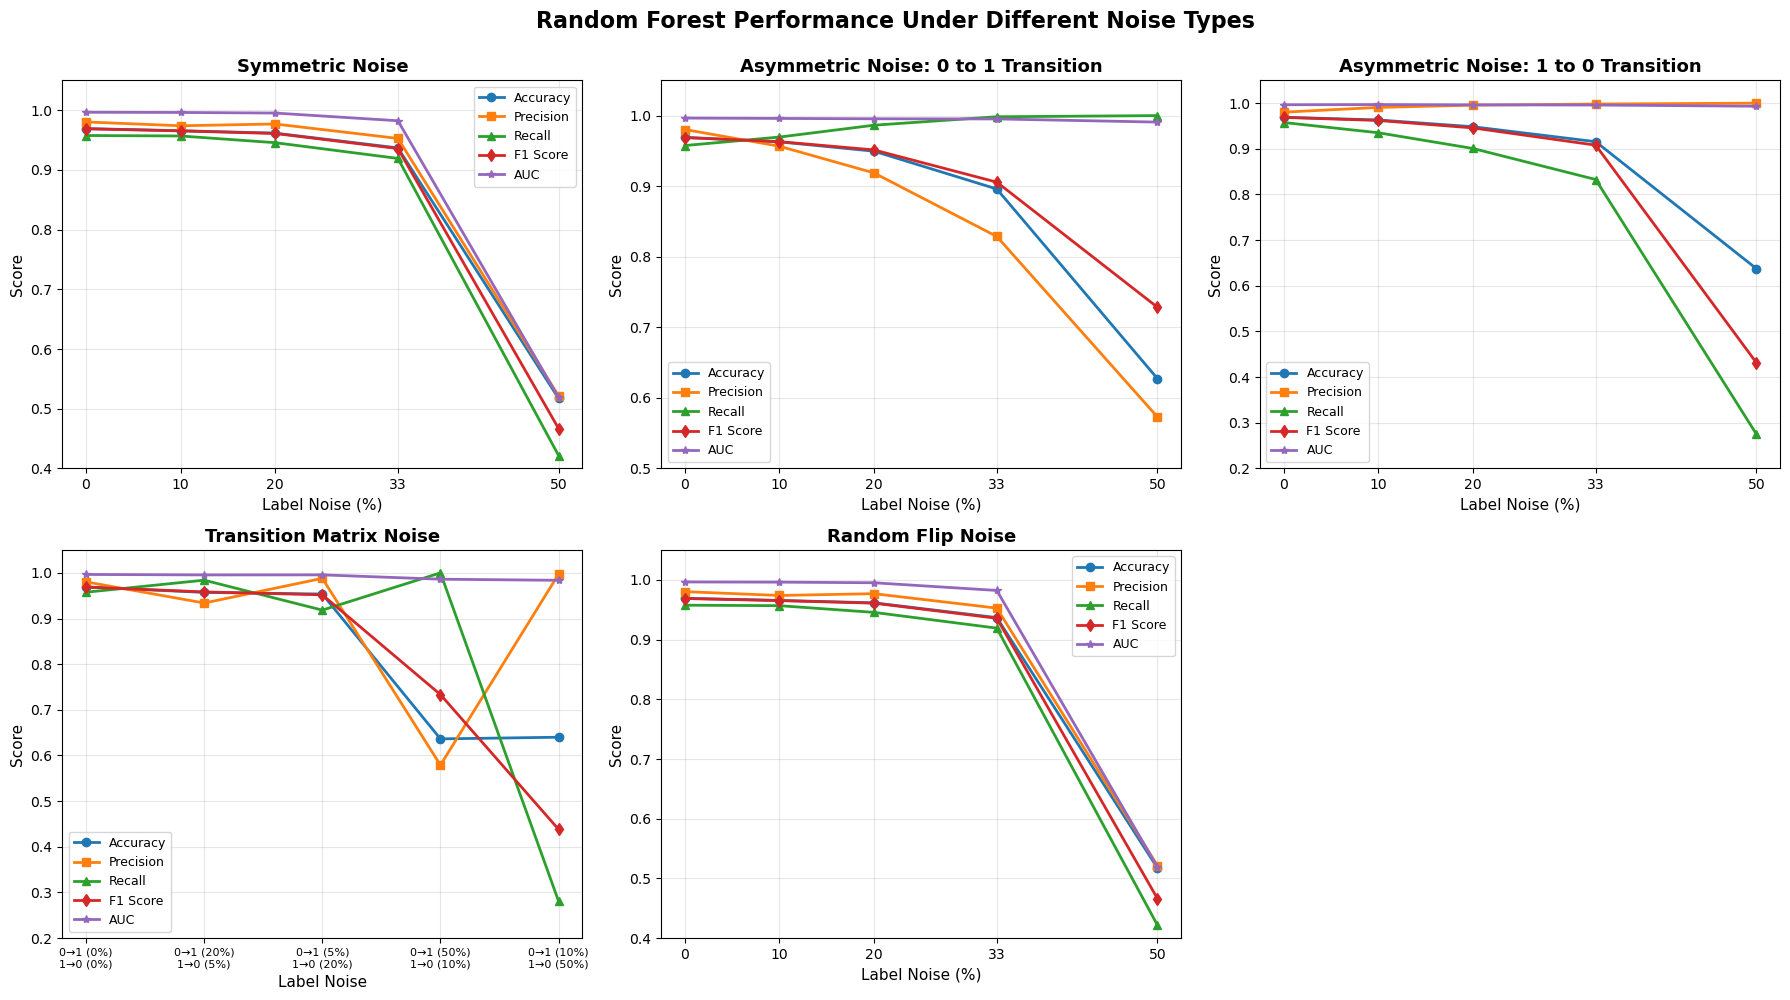

In [65]:
import matplotlib.pyplot as plt

label_noise = [0, 10, 20, 33, 50]

symmetric_accuracy = [0.9692, 0.9656, 0.9616, 0.9368, 0.5172]
symmetric_precision = [0.9803, 0.9739, 0.9769, 0.9527, 0.5213]
symmetric_recall = [0.9576, 0.9568, 0.9456, 0.9192, 0.4216]
symmetric_f1 = [0.9688, 0.9653, 0.9610, 0.9357, 0.4668]
symmetric_auc = [0.9965, 0.9962, 0.9952, 0.9823, 0.5188]

asym_0to1_accuracy = [0.9692, 0.9628, 0.9496, 0.8960, 0.6272]
asym_0to1_precision = [0.9803, 0.9566, 0.9188, 0.8287, 0.5729]
asym_0to1_recall = [0.9576, 0.9696, 0.9864, 0.9984, 1.0000]
asym_0to1_f1 = [0.9688, 0.9631, 0.9514, 0.9057, 0.7284]
asym_0to1_auc = [0.9965, 0.9960, 0.9955, 0.9953, 0.9908]

asym_1to0_accuracy = [0.9692, 0.9632, 0.9484, 0.9156, 0.6376]
asym_1to0_precision = [0.9803, 0.9907, 0.9956, 0.9981, 1.0000]
asym_1to0_recall = [0.9576, 0.9352, 0.9008, 0.8328, 0.2752]
asym_1to0_f1 = [0.9688, 0.9621, 0.9458, 0.9080, 0.4316]
asym_1to0_auc = [0.9965, 0.9969, 0.9963, 0.9959, 0.9933]

random_flip_accuracy = [0.9692, 0.9656, 0.9616, 0.9368, 0.5172]
random_flip_precision = [0.9803, 0.9739, 0.9769, 0.9527, 0.5213]
random_flip_recall = [0.9576, 0.9568, 0.9456, 0.9192, 0.4216]
random_flip_f1 = [0.9688, 0.9653, 0.9610, 0.9357, 0.4662]
random_flip_auc = [0.9965, 0.9962, 0.9952, 0.9823, 0.5188]

transition_labels = ['0→1 (0%)\n1→0 (0%)', '0→1 (20%)\n1→0 (5%)', '0→1 (5%)\n1→0 (20%)', 
                     '0→1 (50%)\n1→0 (10%)', '0→1 (10%)\n1→0 (50%)']
transition_accuracy = [0.9692, 0.9572, 0.9536, 0.6364, 0.6400]
transition_precision = [0.9803, 0.9339, 0.9880, 0.5790, 0.9972]
transition_recall = [0.9576, 0.9840, 0.9184, 1.000, 0.2808]
transition_f1 = [0.9688, 0.9583, 0.9519, 0.7334, 0.4382]
transition_auc = [0.9965, 0.9955, 0.9956, 0.9861, 0.9837]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(label_noise, symmetric_accuracy, marker='o', label='Accuracy', linewidth=2)
axes[0, 0].plot(label_noise, symmetric_precision, marker='s', label='Precision', linewidth=2)
axes[0, 0].plot(label_noise, symmetric_recall, marker='^', label='Recall', linewidth=2)
axes[0, 0].plot(label_noise, symmetric_f1, marker='d', label='F1 Score', linewidth=2)
axes[0, 0].plot(label_noise, symmetric_auc, marker='*', label='AUC', linewidth=2)
axes[0, 0].set_xlabel('Label Noise (%)', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Symmetric Noise', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='best', fontsize=9)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(label_noise)
axes[0, 0].set_ylim(0.4, 1.05)

axes[0, 1].plot(label_noise, asym_0to1_accuracy, marker='o', label='Accuracy', linewidth=2)
axes[0, 1].plot(label_noise, asym_0to1_precision, marker='s', label='Precision', linewidth=2)
axes[0, 1].plot(label_noise, asym_0to1_recall, marker='^', label='Recall', linewidth=2)
axes[0, 1].plot(label_noise, asym_0to1_f1, marker='d', label='F1 Score', linewidth=2)
axes[0, 1].plot(label_noise, asym_0to1_auc, marker='*', label='AUC', linewidth=2)
axes[0, 1].set_xlabel('Label Noise (%)', fontsize=11)
axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title('Asymmetric Noise: 0 to 1 Transition', fontsize=13, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(label_noise)
axes[0, 1].set_ylim(0.5, 1.05)

axes[0, 2].plot(label_noise, asym_1to0_accuracy, marker='o', label='Accuracy', linewidth=2)
axes[0, 2].plot(label_noise, asym_1to0_precision, marker='s', label='Precision', linewidth=2)
axes[0, 2].plot(label_noise, asym_1to0_recall, marker='^', label='Recall', linewidth=2)
axes[0, 2].plot(label_noise, asym_1to0_f1, marker='d', label='F1 Score', linewidth=2)
axes[0, 2].plot(label_noise, asym_1to0_auc, marker='*', label='AUC', linewidth=2)
axes[0, 2].set_xlabel('Label Noise (%)', fontsize=11)
axes[0, 2].set_ylabel('Score', fontsize=11)
axes[0, 2].set_title('Asymmetric Noise: 1 to 0 Transition', fontsize=13, fontweight='bold')
axes[0, 2].legend(loc='best', fontsize=9)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(label_noise)
axes[0, 2].set_ylim(0.2, 1.05)

x = range(len(transition_labels))
axes[1, 0].plot(x, transition_accuracy, marker='o', label='Accuracy', linewidth=2)
axes[1, 0].plot(x, transition_precision, marker='s', label='Precision', linewidth=2)
axes[1, 0].plot(x, transition_recall, marker='^', label='Recall', linewidth=2)
axes[1, 0].plot(x, transition_f1, marker='d', label='F1 Score', linewidth=2)
axes[1, 0].plot(x, transition_auc, marker='*', label='AUC', linewidth=2)
axes[1, 0].set_xlabel('Label Noise', fontsize=11)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Transition Matrix Noise', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(transition_labels, fontsize=8)
axes[1, 0].legend(loc='best', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0.2, 1.05)

axes[1, 1].plot(label_noise, random_flip_accuracy, marker='o', label='Accuracy', linewidth=2)
axes[1, 1].plot(label_noise, random_flip_precision, marker='s', label='Precision', linewidth=2)
axes[1, 1].plot(label_noise, random_flip_recall, marker='^', label='Recall', linewidth=2)
axes[1, 1].plot(label_noise, random_flip_f1, marker='d', label='F1 Score', linewidth=2)
axes[1, 1].plot(label_noise, random_flip_auc, marker='*', label='AUC', linewidth=2)
axes[1, 1].set_xlabel('Label Noise (%)', fontsize=11)
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title('Random Flip Noise', fontsize=13, fontweight='bold')
axes[1, 1].legend(loc='best', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(label_noise)
axes[1, 1].set_ylim(0.4, 1.05)

axes[1, 2].axis('off')

plt.suptitle('Random Forest Performance Under Different Noise Types', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()